**Name:** Tanmay Gawande  
**Roll No:** DA25M030

# Fourier Transform - Hands-on Notebook

This notebook contains theory and runnable code examples for:
- Fourier transform and it's properties

Run the cells in order. Change parameters in the **Try-it** cells to explore.

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import convolve
from scipy.signal import medfilt2d
import os
from numpy.fft import fft2, ifft2, fftshift
import time

import urllib.request

save_path = "cameraman.jpeg"

if not os.path.exists(save_path):
    urls = [
        "https://raw.githubusercontent.com/scikit-image/scikit-image/main/skimage/data/camera.png",
        "https://raw.githubusercontent.com/scikit-image/scikit-image/v0.24.0/skimage/data/camera.png",
    ]
    ok = False
    for u in urls:
        try:
            with urllib.request.urlopen(u, timeout=15) as r:
                data = np.asarray(bytearray(r.read()), dtype=np.uint8)
            img = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                cv2.imwrite(save_path, img)  # save locally as jpeg
                ok = True
                print(f"Saved {save_path} from: {u}")
                break
        except Exception:
            pass
    if not ok:
        raise RuntimeError("Could not download cameraman image from fallback URLs.")
else:
    print(f"{save_path} already exists.")


cameraman.jpeg already exists.


### Intuition: The 1D Fourier Transform as a Sum of Cosines

**The core idea**

Any signal can be written as a sum of cosines (and sines) at different frequencies. The Fourier Transform tells you **which frequencies are present** and **how much of each**.

**Continuous case**

A continuous signal $f(t)$ is decomposed into a continuum of frequencies:

$$
f(t) = \int_{-\infty}^{\infty} F(\nu)\; e^{j2\pi \nu t}\; d\nu
$$

where $F(\nu)$ is the Fourier Transform:

$$
F(\nu) = \int_{-\infty}^{\infty} f(t)\; e^{-j2\pi \nu t}\; dt
$$

Using Euler's formula $e^{j\theta} = \cos\theta + j\sin\theta$, each frequency component $F(\nu)\, e^{j2\pi \nu t}$ is a sinusoid. Writing $F(\nu) = |F(\nu)|\, e^{j\phi(\nu)}$:

$$
f(t) = \int_{-\infty}^{\infty} |F(\nu)|\; \cos(2\pi \nu t + \phi(\nu))\; d\nu
$$

So $f(t)$ is literally a (continuous) sum of cosines, each with:
- frequency $\nu$
- amplitude $|F(\nu)|$ (how strong)
- phase $\phi(\nu)$ (where it starts)

**Discrete case**

We have $N$ samples $f[0], f[1], \ldots, f[N{-}1]$. The DFT gives $N$ frequency coefficients:

$$
F[k] = \sum_{n=0}^{N-1} f[n]\; e^{-j2\pi kn/N}, \quad k = 0, 1, \ldots, N{-}1
$$

The inverse DFT reconstructs the signal as a **finite sum** of $N$ cosines:

$$
f[n] = \frac{1}{N}\sum_{k=0}^{N-1} |F[k]|\; \cos\!\left(\frac{2\pi k n}{N} + \phi_k\right)
$$

where $|F[k]|$ is the magnitude and $\phi_k = \angle F[k]$ is the phase of the $k$-th coefficient.

**How to read this**

Each term in the sum is a cosine that completes exactly $k$ full cycles over the $N$ samples:

| $k$ | Meaning |
|---|---|
| $k = 0$ | DC (constant offset), frequency = 0 |
| $k = 1$ | Slowest oscillation: 1 cycle over $N$ samples |
| $k = 2$ | 2 cycles over $N$ samples |
| $\vdots$ | $\vdots$ |
| $k = N/2$ | Fastest oscillation (Nyquist): alternates every sample |

The magnitude spectrum $|F[k]|$ tells you how much of each frequency is present. A signal with only low-$k$ components is smooth; one with large high-$k$ components has sharp features.

**Continuous vs discrete — key differences**

| | Continuous FT | Discrete FT (DFT) |
|---|---|---|
| Signal | $f(t)$, infinite duration | $f[n]$, $N$ samples |
| Frequencies | Continuous $\nu \in (-\infty, \infty)$ | Discrete $k = 0, 1, \ldots, N{-}1$ |
| Transform | Integral | Finite sum |
| Reconstruction | Integral over all $\nu$ | Sum of $N$ cosines |
| Periodicity | Not assumed | Signal treated as periodic with period $N$ |
| Highest frequency | Unlimited | Nyquist: $k = N/2$ (limited by sampling) |

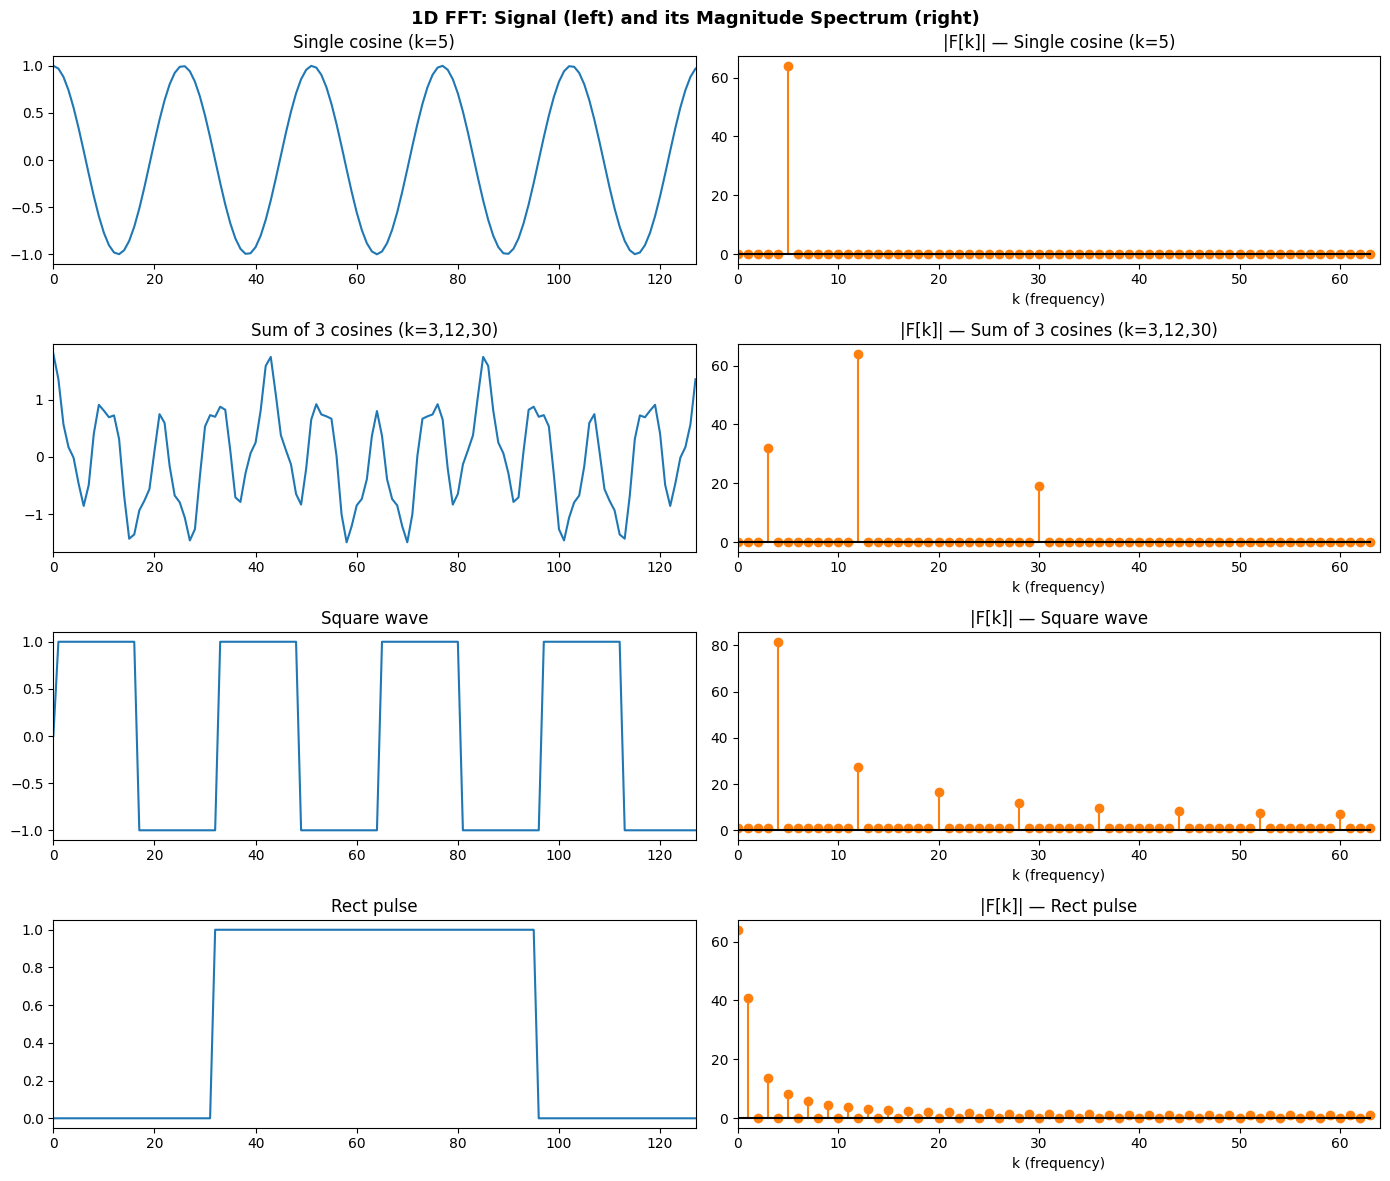

In [2]:
N = 128
n = np.arange(N)

# ===== Example 1: Single cosine — one frequency =====
k0 = 5
f1 = np.cos(2 * np.pi * k0 * n / N)

# ===== Example 2: Sum of three cosines =====
f2 = 0.5 * np.cos(2 * np.pi * 3 * n / N) + 1.0 * np.cos(2 * np.pi * 12 * n / N) + 0.3 * np.cos(2 * np.pi * 30 * n / N)

# ===== Example 3: Square wave (many frequencies) =====
f3 = np.sign(np.sin(2 * np.pi * 4 * n / N))

# ===== Example 4: Reconstruct a signal by adding cosines one by one =====
f4 = np.zeros(N)
f4[N//4:3*N//4] = 1.0  # rect pulse

F4 = np.fft.fft(f4)
freqs = np.arange(N)

signals = [(f1, "Single cosine (k=5)"),
           (f2, "Sum of 3 cosines (k=3,12,30)"),
           (f3, "Square wave"),
           (f4, "Rect pulse")]

# --- Plot signals and their magnitude spectra ---
fig, axes = plt.subplots(4, 2, figsize=(14, 12))

for i, (sig, label) in enumerate(signals):
    F = np.fft.fft(sig)
    mag = np.abs(F[:N//2])  # only positive frequencies

    axes[i,0].plot(n, sig, 'C0-')
    axes[i,0].set_title(label)
    axes[i,0].set_xlim(0, N-1)

    axes[i,1].stem(np.arange(N//2), mag, markerfmt='C1o', basefmt='k-', linefmt='C1-')
    axes[i,1].set_title(f"|F[k]| — {label}")
    axes[i,1].set_xlim(0, N//2)
    axes[i,1].set_xlabel("k (frequency)")

fig.suptitle("1D FFT: Signal (left) and its Magnitude Spectrum (right)", fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

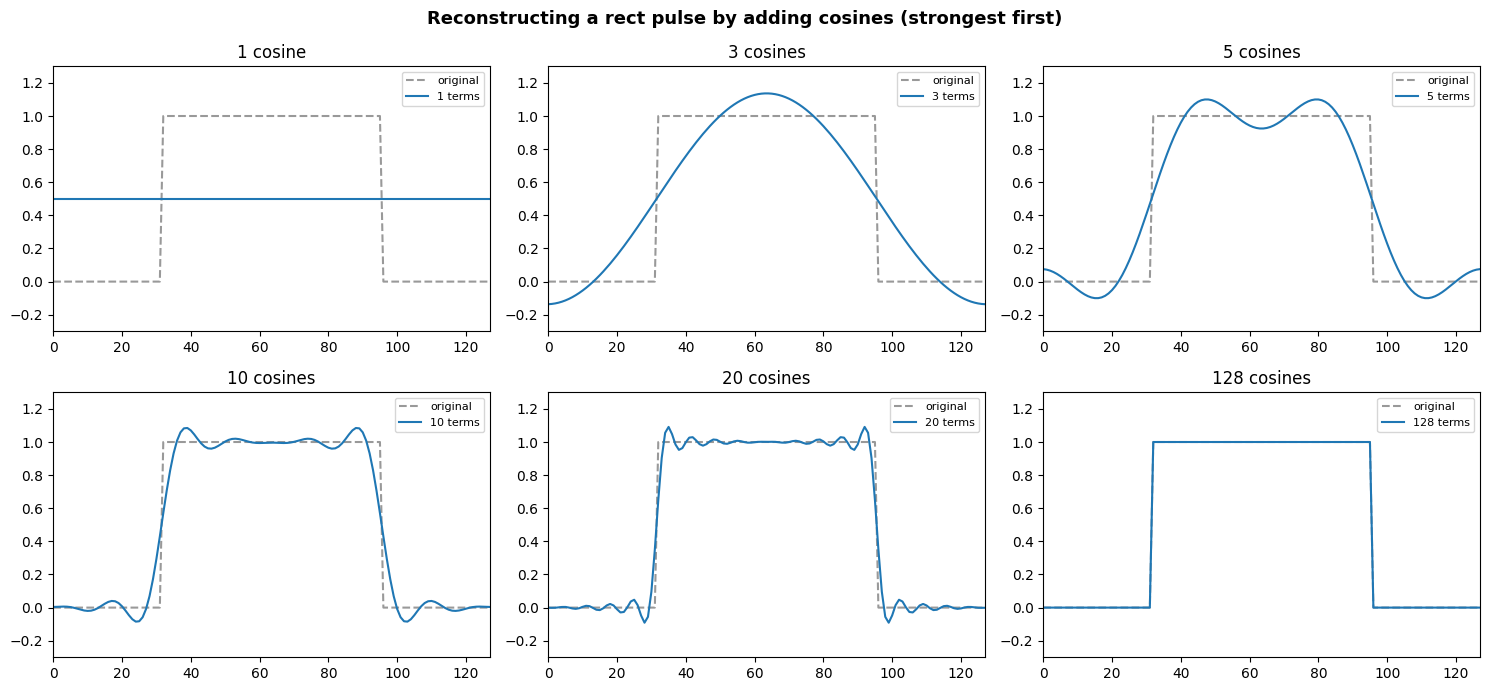

In [3]:
# ===== Progressive reconstruction: adding cosines one by one =====
f_rect = np.zeros(N)
f_rect[N//4:3*N//4] = 1.0

F_rect = np.fft.fft(f_rect)

# Sort frequency components by magnitude (largest first)
order = np.argsort(-np.abs(F_rect))

num_terms = [1, 3, 5, 10, 20, N]

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.ravel()

for idx, K in enumerate(num_terms):
    # Reconstruct using only top-K frequency components
    F_partial = np.zeros(N, dtype=complex)
    F_partial[order[:K]] = F_rect[order[:K]]
    f_partial = np.real(np.fft.ifft(F_partial))

    axes[idx].plot(n, f_rect, 'k--', alpha=0.4, label='original')
    axes[idx].plot(n, f_partial, 'C0-', linewidth=1.5, label=f'{K} terms')
    axes[idx].set_title(f"{K} cosine{'s' if K > 1 else ''}")
    axes[idx].set_xlim(0, N-1)
    axes[idx].set_ylim(-0.3, 1.3)
    axes[idx].legend(fontsize=8)

fig.suptitle("Reconstructing a rect pulse by adding cosines (strongest first)",
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

## Exercise: Implement DFT / IDFT

Implement the 2D **Discrete Fourier Transform (DFT)** and its **Inverse (IDFT)**.

**Forward DFT:**

$$
F(u,v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y)\; e^{-j\,2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}
$$

**Inverse DFT:**

$$
f(x,y) = \frac{1}{MN} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} F(u,v)\; e^{+j\,2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}
$$

The manual implementation is $O(M^2 N^2)$, very slow compared to NumPy's FFT ($O(MN \log(MN))$).

For each test image compare:
1. **DFT magnitude spectrum** vs **NumPy FFT magnitude spectrum** (should match)
2. **IDFT reconstruction** vs **original image** (round-trip: should recover the original)

In [4]:
def dft_2d(image):
    """Compute the 2D DFT of an image using explicit for-loops."""
    M, N = image.shape
    F = np.zeros((M, N), dtype=np.complex128)
    for u in range(M):
        for v in range(N):
            total = 0.0 + 0.0j
            for x in range(M):
                for y in range(N):
                    exponent = np.exp(-2j * np.pi * ((u * x) / M + (v * y) / N))
                    total += exponent
            F[u, v] = total

    return F

In [5]:
def idft_2d(F):
    """Compute the 2D Inverse DFT of a frequency-domain image using explicit for-loops."""
    M, N = F.shape
    image = np.zeros((M, N), dtype=np.complex128)
    for x in range(M):
        for y in range(N):
            total = 0.0 + 0.0j
            for u in range(M):
                for v in range(N):
                    exponent = np.exp(+2j * np.pi * ((u * x) / M + (v * y) / N))
                    total += exponent
            image[x, y] = total
    image = image / (M * N)
    return np.real(image)

In [6]:
SIZE = 32  # keep small so manual DFT finishes in reasonable time

# 1. Solid (constant) image
solid = np.ones((SIZE, SIZE), dtype=np.float64)

# 2. Step edge (vertical)
step_x = np.zeros((SIZE, SIZE), dtype=np.float64)
step_x[:, SIZE // 2:] = 1.0

# 3. Step edge (horizontal)
step_y = np.zeros((SIZE, SIZE), dtype=np.float64)
step_y[SIZE // 2:, :] = 1.0

# 4. Sinusoid (vertical stripes)
xs = np.linspace(0, 2 * np.pi, SIZE)
xx, _ = np.meshgrid(xs, xs)
sin_x = 0.5 * (1 + np.sin(5 * xx))

# 5. Sinusoid (horizontal stripes)
_, yy = np.meshgrid(xs, xs)
sin_y = 0.5 * (1 + np.sin(5 * yy))

# 6. Chessboard
sq = SIZE // 4
cx = np.arange(SIZE)
CX, CY = np.meshgrid(cx, cx)
chess = ((CX // sq) + (CY // sq)) % 2
chess = chess.astype(np.float64)

# 7. Cameraman (resized to SIZE×SIZE so manual DFT is feasible)
cam_path = "cameraman.jpeg"
if os.path.exists(cam_path):
    cam_full = cv2.imread(cam_path, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
    cam_small = cv2.resize(cam_full, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
else:
    print(f"⚠️  '{cam_path}' not found - skipping cameraman image.")
    cam_small = None

### A note on `fftshift`

By default, `np.fft.fft2` places the **zero-frequency (DC)** component at the top-left corner `(0, 0)`. Positive and negative frequencies are split across opposite corners, making the spectrum hard to interpret visually.

`np.fft.fftshift` simply **swaps the quadrants** so that DC moves to the **center** of the image:

`fftshift` is purely a rearrangement, it does not change any values or lose any information. It is the equivalent of a circular shift by `N//2` along each axis. Its inverse, `ifftshift`, undoes it exactly. We use it only to make plots look natural (low frequencies at center, high frequencies at edges).

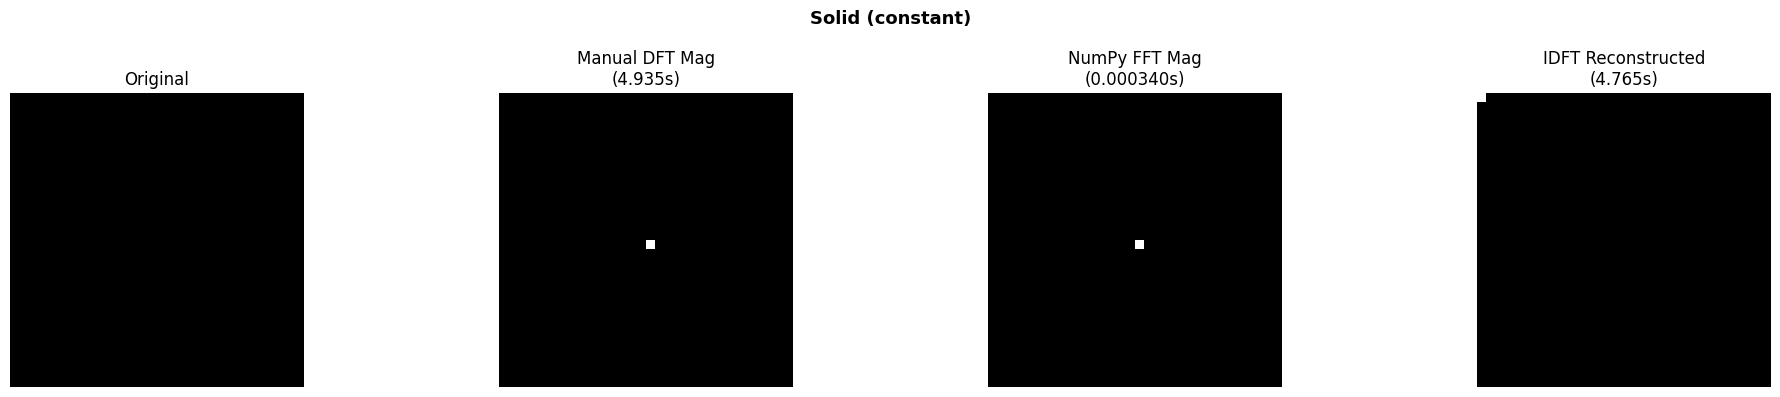

  DFT vs FFT  -> max err: 2.65e-12, mean err: 1.31e-13
  IDFT recon  -> max err: 1.00e+00, mean err: 9.99e-01



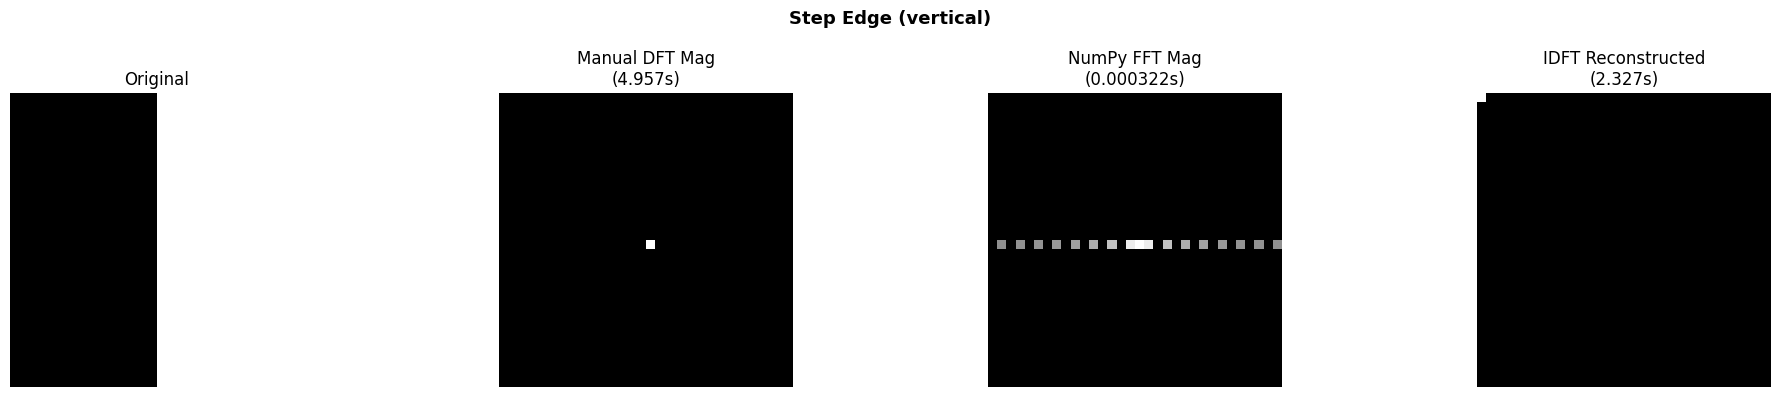

  DFT vs FFT  -> max err: 5.12e+02, mean err: 1.86e+00
  IDFT recon  -> max err: 1.00e+00, mean err: 5.01e-01



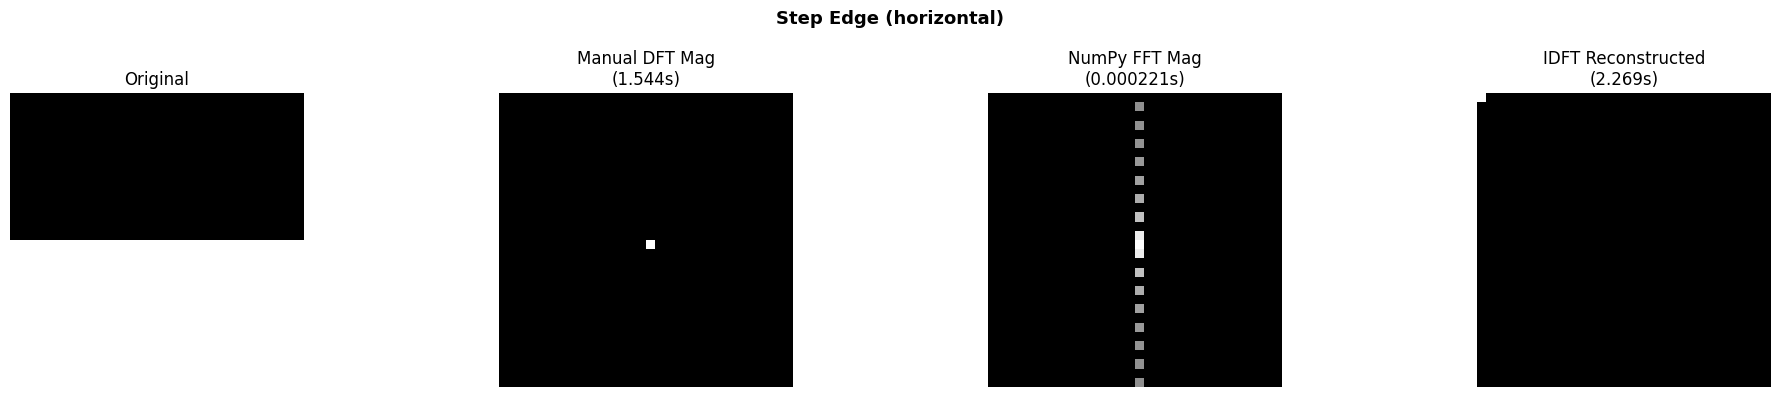

  DFT vs FFT  -> max err: 5.12e+02, mean err: 1.86e+00
  IDFT recon  -> max err: 1.00e+00, mean err: 5.01e-01



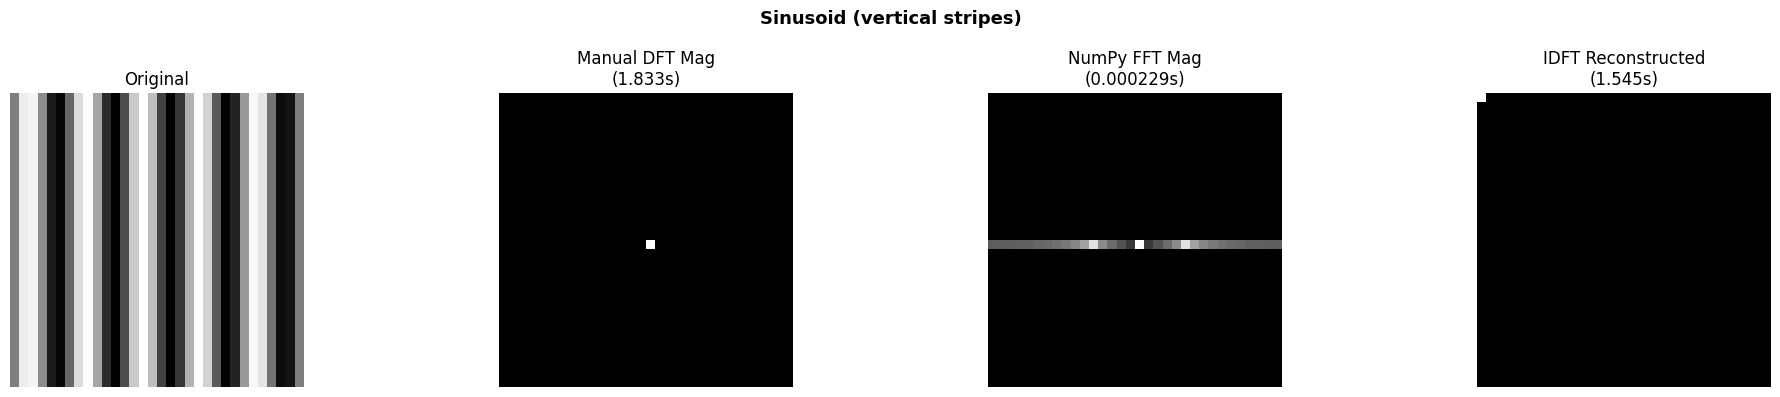

  DFT vs FFT  -> max err: 5.12e+02, mean err: 1.41e+00
  IDFT recon  -> max err: 9.99e-01, mean err: 5.00e-01



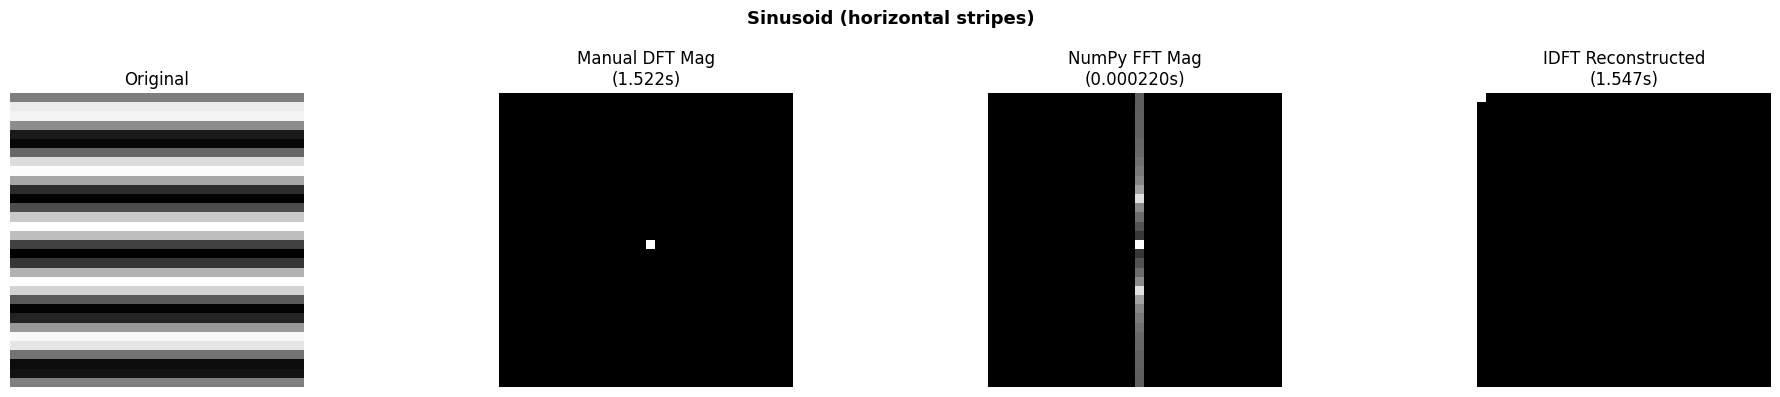

  DFT vs FFT  -> max err: 5.12e+02, mean err: 1.41e+00
  IDFT recon  -> max err: 9.99e-01, mean err: 5.00e-01



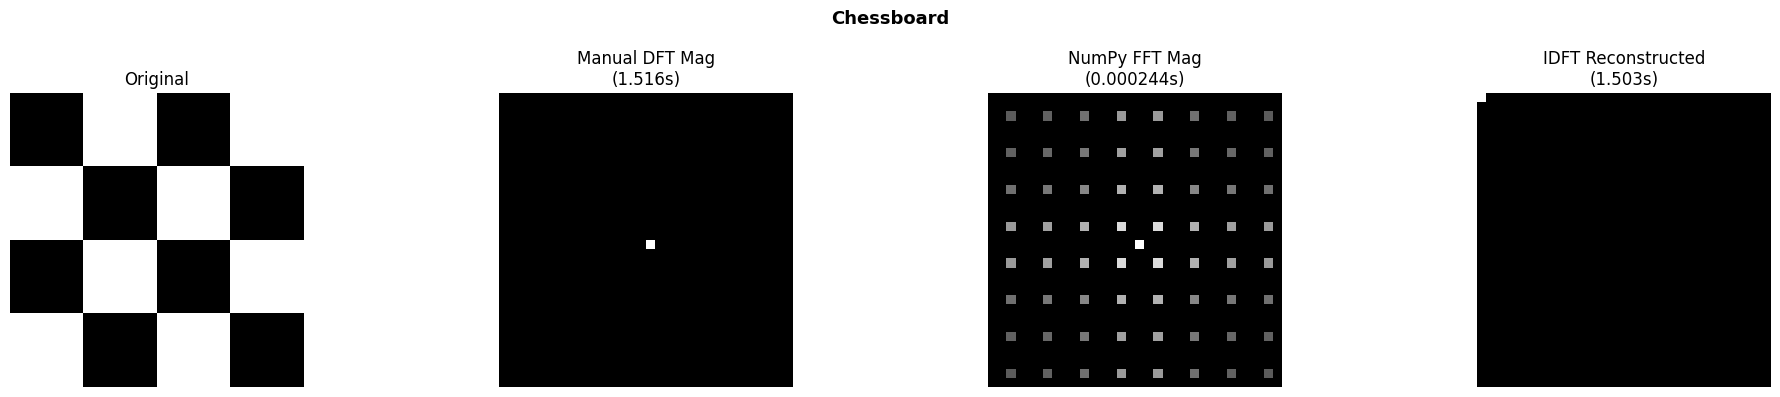

  DFT vs FFT  -> max err: 5.12e+02, mean err: 3.12e+00
  IDFT recon  -> max err: 1.00e+00, mean err: 5.01e-01



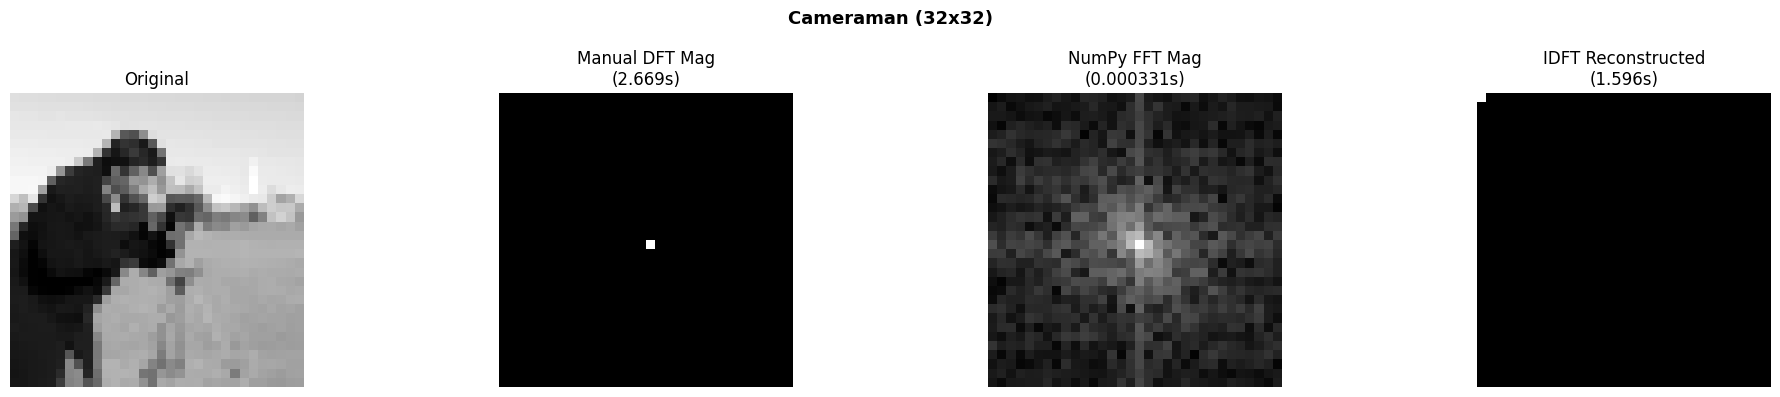

  DFT vs FFT  -> max err: 5.06e+02, mean err: 4.02e+00
  IDFT recon  -> max err: 8.96e-01, mean err: 5.06e-01



In [7]:
def compare_dft_vs_fft(image, title="Image"):
    """
    1. Compute manual DFT and NumPy FFT, compare magnitude spectra
    2. Reconstruct image via manual IDFT, compare to original
    """

    # ---- Manual DFT ----
    t0 = time.time()
    F_manual = dft_2d(image)
    t_dft = time.time() - t0

    # ---- NumPy FFT ----
    t0 = time.time()
    F_numpy = np.fft.fft2(image)
    t_fft = time.time() - t0

    # ---- Shift & log-magnitude for visualization ----
    mag_manual = np.log1p(np.abs(np.fft.fftshift(F_manual)))
    mag_numpy  = np.log1p(np.abs(np.fft.fftshift(F_numpy)))

    # ---- Reconstruct image from manual DFT via manual IDFT ----
    t0 = time.time()
    reconstructed = idft_2d(F_manual)
    t_idft = time.time() - t0

    # ---- Errors ----
    max_spectrum_err = np.max(np.abs(F_manual - F_numpy))
    mean_spectrum_err = np.mean(np.abs(F_manual - F_numpy))
    max_recon_err = np.max(np.abs(reconstructed - image))
    mean_recon_err = np.mean(np.abs(reconstructed - image))

    # ---- Plot ----
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(mag_manual, cmap='gray')
    axes[1].set_title(f"Manual DFT Mag\n({t_dft:.3f}s)")
    axes[1].axis('off')

    axes[2].imshow(mag_numpy, cmap='gray')
    axes[2].set_title(f"NumPy FFT Mag\n({t_fft:.6f}s)")
    axes[2].axis('off')

    axes[3].imshow(reconstructed, cmap='gray')
    axes[3].set_title(f"IDFT Reconstructed\n({t_idft:.3f}s)")
    axes[3].axis('off')

    fig.suptitle(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"  DFT vs FFT  -> max err: {max_spectrum_err:.2e}, mean err: {mean_spectrum_err:.2e}")
    print(f"  IDFT recon  -> max err: {max_recon_err:.2e}, mean err: {mean_recon_err:.2e}")
    print()

test_images = [
    (solid,     "Solid (constant)"),
    (step_x,    "Step Edge (vertical)"),
    (step_y,    "Step Edge (horizontal)"),
    (sin_x,     "Sinusoid (vertical stripes)"),
    (sin_y,     "Sinusoid (horizontal stripes)"),
    (chess,     "Chessboard"),
]

if cam_small is not None:
    test_images.append((cam_small, f"Cameraman ({SIZE}x{SIZE})"))

for img_arr, name in test_images:
    compare_dft_vs_fft(img_arr, title=name)

## Properties of the 2D Discrete Fourier Transform

We demonstrate a few properties of the 2D DFT using simple images.  
All demos use `np.fft.fft2` (fast) since the point here is to visualize each property, not to benchmark.

In [8]:
PROP_SIZE = 128

# Load cameraman at PROP_SIZE for property demos
cam_prop = cv2.imread("cameraman.jpeg", cv2.IMREAD_GRAYSCALE)
cam_prop = cv2.resize(cam_prop, (PROP_SIZE, PROP_SIZE)).astype(np.float64) / 255.0


### 1. Separability

The 2D DFT can be split into successive 1D DFTs. Starting from the definition:

$$
F(u,v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y)\; e^{-j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}
$$

We can factor the exponential since it is a product of two independent terms:

$$
F(u,v) = \sum_{x=0}^{M-1} e^{-j2\pi \frac{ux}{M}} \underbrace{\left[\sum_{y=0}^{N-1} f(x,y)\; e^{-j2\pi \frac{vy}{N}}\right]}_{\text{1D FFT of row } x}
$$

So the computation is:

**Step 1 - Row FFT:** For each row $x$, compute the 1D FFT along columns:

$$
\tilde{F}(x, v) = \sum_{y=0}^{N-1} f(x,y)\; e^{-j2\pi \frac{vy}{N}}
$$

**Step 2 - Column FFT:** For each frequency $v$, compute the 1D FFT along rows:

$$
F(u, v) = \sum_{x=0}^{M-1} \tilde{F}(x, v)\; e^{-j2\pi \frac{ux}{M}}
$$

This is why `np.fft.fft2` internally runs 1D FFTs on rows, then on columns.

For separable images $f(x,y) = g(x) \cdot h(y)$, this simplifies further to $F(u,v) = G(u) \cdot H(v)$.

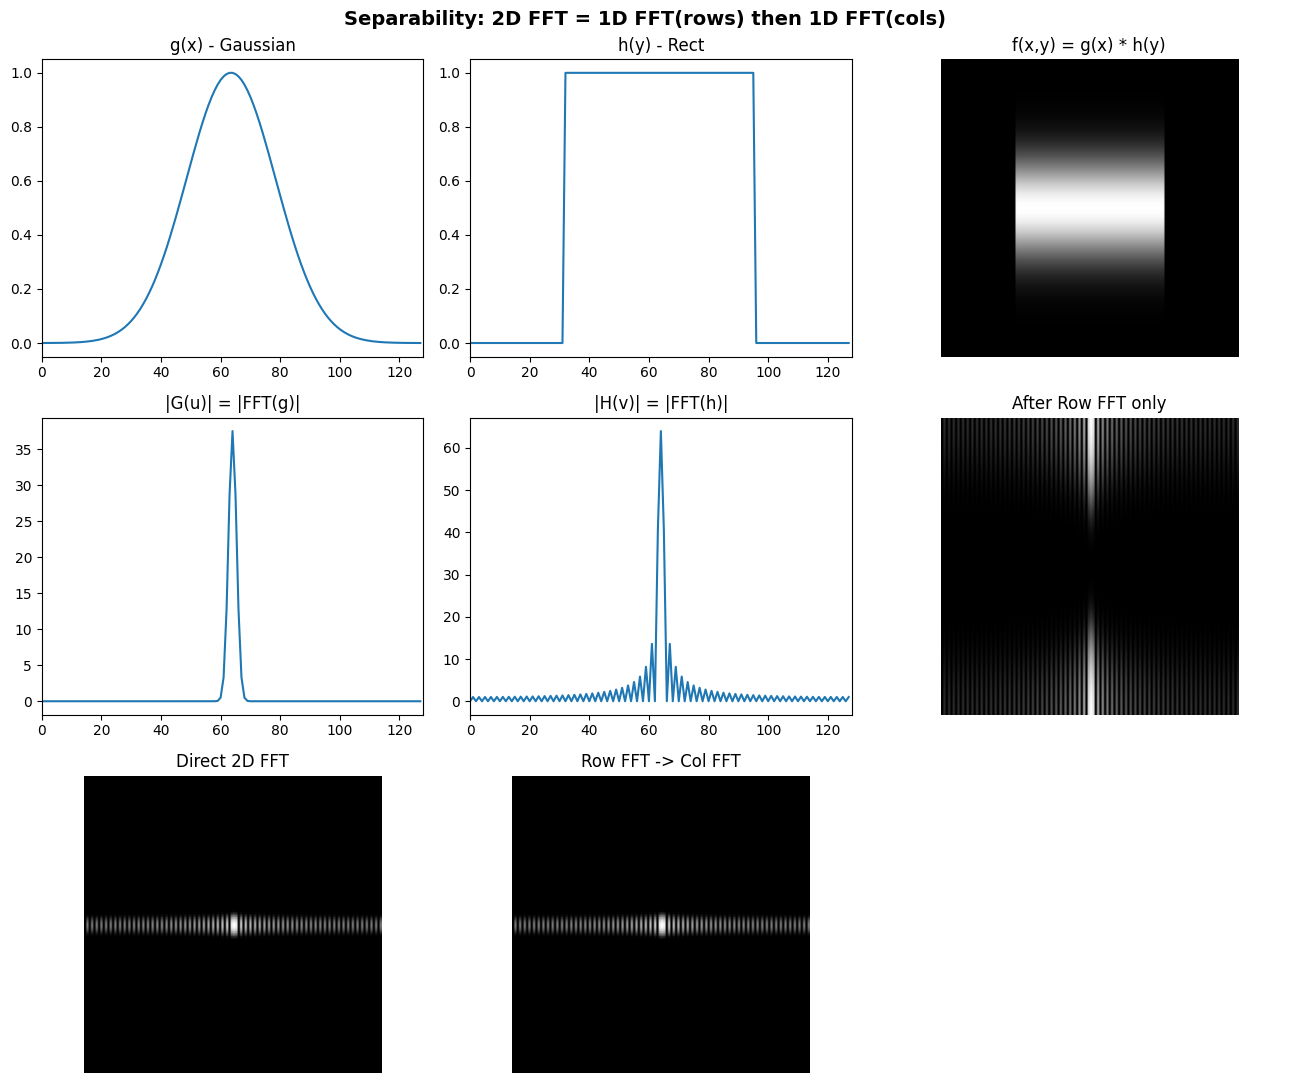

Max error (Direct 2D vs Separable): 0.00e+00
Mean error (Direct 2D vs Separable): 0.00e+00


In [9]:
N = PROP_SIZE

# ---- 1D signals ----
g = np.exp(-np.linspace(-3, 3, N)**2)
h = np.zeros(N); h[N//4:3*N//4] = 1.0

f_sep = np.outer(g, h)

# ===== Method 1: Direct 2D FFT =====
F_2d = np.fft.fft2(f_sep)
F_2d_shifted = np.fft.fftshift(F_2d)

# ===== Method 2: Separable - 1D FFT along rows, then along columns =====
F_rows = np.fft.fft(f_sep, axis=1)
F_sep_manual = np.fft.fft(F_rows, axis=0)
F_sep_shifted = np.fft.fftshift(F_sep_manual)

# ---- Magnitudes (log-scaled for display) ----
mag_2d  = np.log1p(np.abs(F_2d_shifted))
mag_sep = np.log1p(np.abs(F_sep_shifted))
mag_rows_only = np.log1p(np.abs(np.fft.fftshift(F_rows)))

diff = np.abs(F_2d_shifted - F_sep_shifted)

fig, axes = plt.subplots(3, 3, figsize=(13, 11))

# Row 0: Spatial - 1D components and outer product
axes[0,0].plot(g)
axes[0,0].set_title(f"g(x) - Gaussian")
axes[0,0].set_xlim(0, N)

axes[0,1].plot(h)
axes[0,1].set_title(f"h(y) - Rect")
axes[0,1].set_xlim(0, N)

axes[0,2].imshow(f_sep, cmap='gray')
axes[0,2].set_title(f"f(x,y) = g(x) * h(y)")
axes[0,2].axis('off')

# Row 1: 1D spectra and intermediate row-FFT
axes[1,0].plot(np.abs(np.fft.fftshift(np.fft.fft(g))))
axes[1,0].set_title("|G(u)| = |FFT(g)|")
axes[1,0].set_xlim(0, N)

axes[1,1].plot(np.abs(np.fft.fftshift(np.fft.fft(h))))
axes[1,1].set_title("|H(v)| = |FFT(h)|")
axes[1,1].set_xlim(0, N)

axes[1,2].imshow(mag_rows_only, cmap='gray')
axes[1,2].set_title("After Row FFT only")
axes[1,2].axis('off')

# Row 2: Direct 2D FFT vs Separable
axes[2,0].imshow(mag_2d, cmap='gray')
axes[2,0].set_title("Direct 2D FFT")
axes[2,0].axis('off')

axes[2,1].imshow(mag_sep, cmap='gray')
axes[2,1].set_title("Row FFT -> Col FFT")
axes[2,1].axis('off')

axes[2,2].axis('off')

fig.suptitle("Separability: 2D FFT = 1D FFT(rows) then 1D FFT(cols)", fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

print(f"Max error (Direct 2D vs Separable): {diff.max():.2e}")
print(f"Mean error (Direct 2D vs Separable): {diff.mean():.2e}")

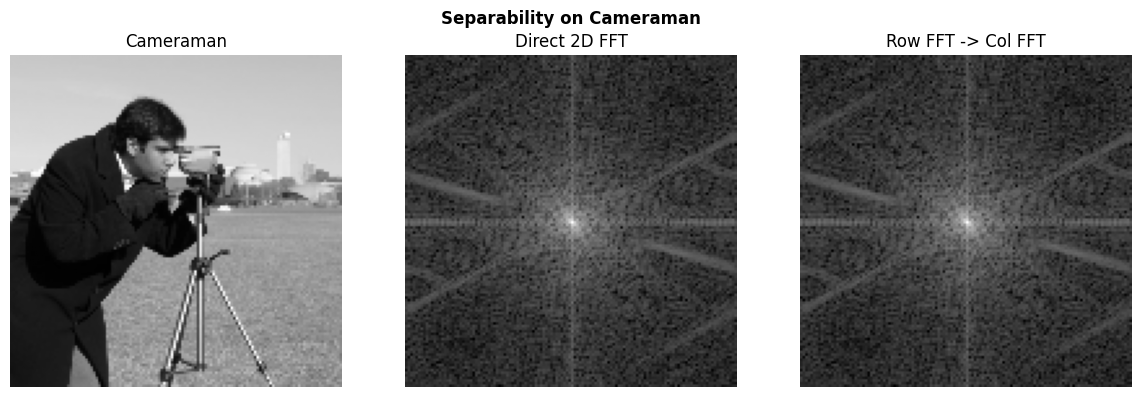

Max error: 0.00e+00, Mean error: 0.00e+00


In [10]:
# Separability on cameraman
F_2d_cam = np.fft.fft2(cam_prop)
F_rows_cam = np.fft.fft(cam_prop, axis=1)
F_sep_cam = np.fft.fft(F_rows_cam, axis=0)

mag_2d_cam = np.log1p(np.abs(np.fft.fftshift(F_2d_cam)))
mag_sep_cam = np.log1p(np.abs(np.fft.fftshift(F_sep_cam)))

diff_cam = np.abs(F_2d_cam - F_sep_cam)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(cam_prop, cmap='gray'); axes[0].set_title("Cameraman"); axes[0].axis('off')
axes[1].imshow(mag_2d_cam, cmap='gray'); axes[1].set_title("Direct 2D FFT"); axes[1].axis('off')
axes[2].imshow(mag_sep_cam, cmap='gray'); axes[2].set_title("Row FFT -> Col FFT"); axes[2].axis('off')
fig.suptitle("Separability on Cameraman", fontsize=12, fontweight='bold')
plt.tight_layout(); plt.show()
print(f"Max error: {diff_cam.max():.2e}, Mean error: {diff_cam.mean():.2e}")

### 2. Translation (Spatial Shift)

Shifting an image in the spatial domain only changes the phase of its Fourier transform, the magnitude remains unchanged:

$$f(x - x_0,\; y - y_0) \;\longleftrightarrow\; F(u,v)\; e^{-j2\pi\left(\frac{u x_0}{M} + \frac{v y_0}{N}\right)}$$

We demonstrate with a bright rectangle shifted by $(30, 20)$ pixels.

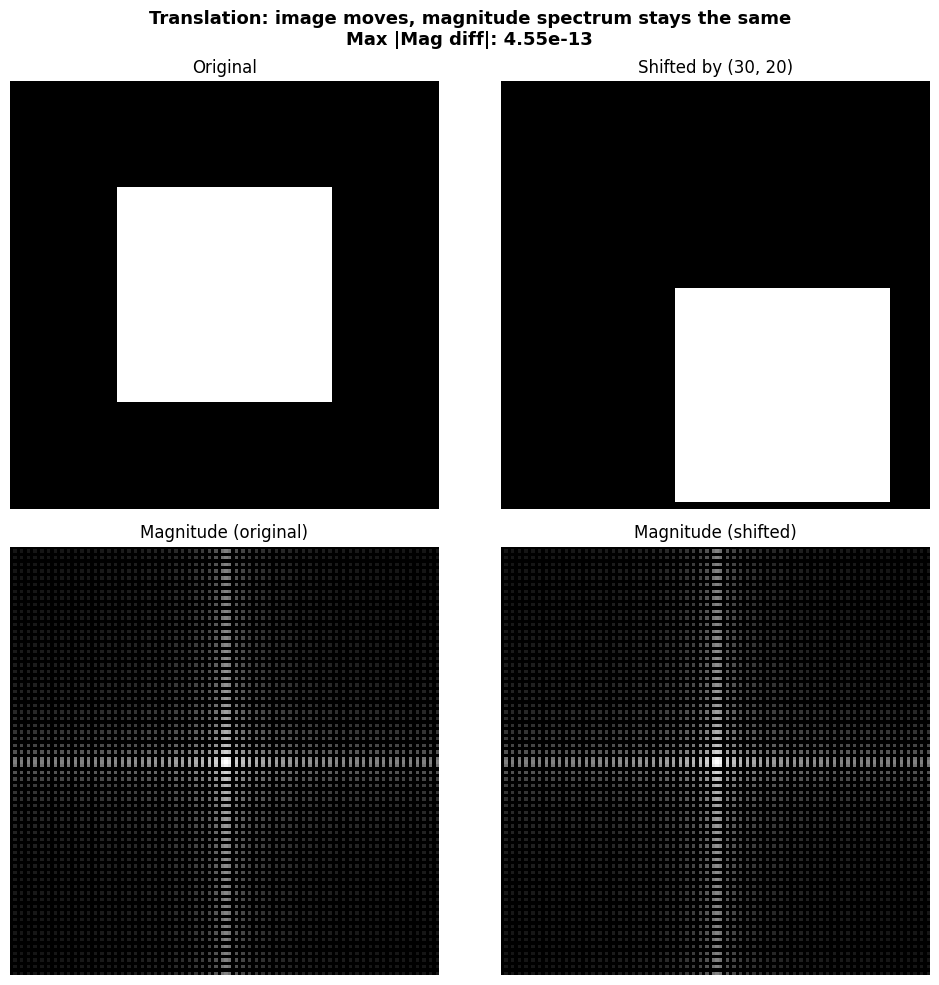

In [11]:
N = PROP_SIZE

# --- Image: bright rectangle ---
rect = np.zeros((N, N))
rect[N//4:3*N//4, N//4:3*N//4] = 1.0

# --- Shift by (dx, dy) ---
dx, dy = 30, 20
rect_shifted = np.roll(np.roll(rect, dx, axis=0), dy, axis=1)

# --- FFTs ---
F_orig = np.fft.fft2(rect)
F_shift = np.fft.fft2(rect_shifted)

mag_diff = np.max(np.abs(np.abs(F_orig) - np.abs(F_shift)))


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0,0].imshow(rect, cmap='gray')
axes[0,0].set_title("Original"); axes[0,0].axis('off')

axes[0,1].imshow(rect_shifted, cmap='gray')
axes[0,1].set_title(f"Shifted by ({dx}, {dy})"); axes[0,1].axis('off')

axes[1,0].imshow(np.log1p(np.abs(np.fft.fftshift(F_orig))), cmap='gray')
axes[1,0].set_title("Magnitude (original)"); axes[1,0].axis('off')

axes[1,1].imshow(np.log1p(np.abs(np.fft.fftshift(F_shift))), cmap='gray')
axes[1,1].set_title("Magnitude (shifted)"); axes[1,1].axis('off')

fig.suptitle(f"Translation: image moves, magnitude spectrum stays the same\nMax |Mag diff|: {mag_diff:.2e}",
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

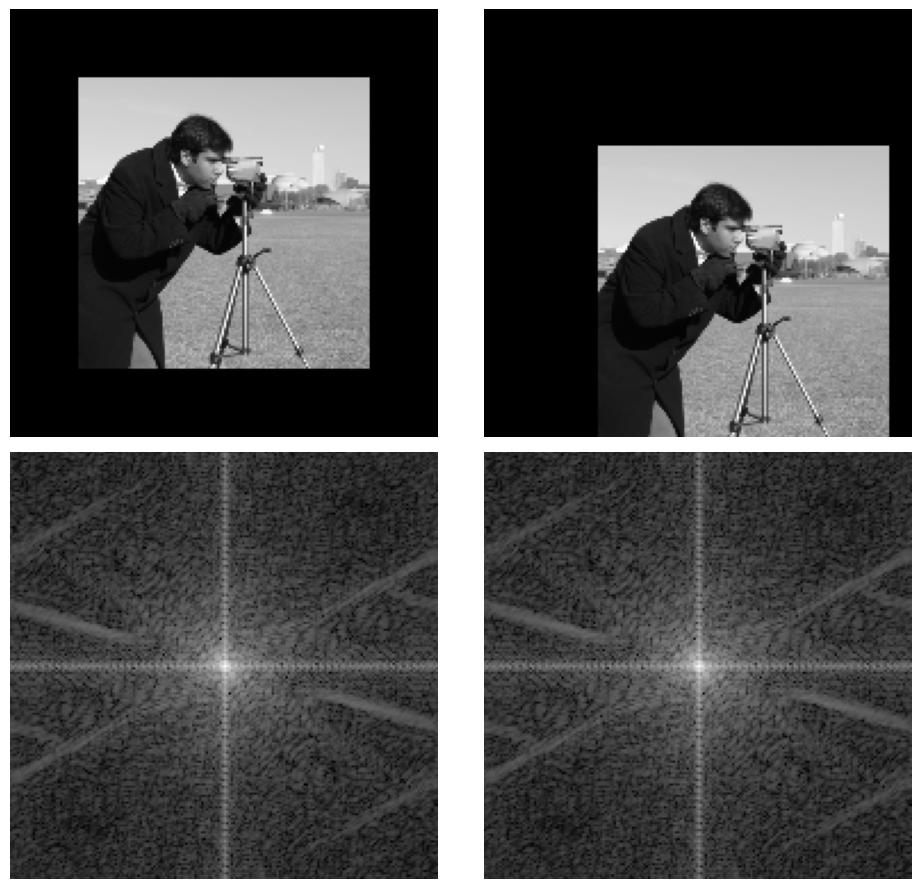

Max magnitude diff: 1.82e-12


In [12]:
N = PROP_SIZE
dx, dy = 30, 20

pad = max(abs(dx), abs(dy))
N_big = N + 2 * pad
cam_big = np.zeros((N_big, N_big))
cam_big[pad:pad+N, pad:pad+N] = cam_prop

cam_big_shifted = np.roll(np.roll(cam_big, dx, axis=0), dy, axis=1)

F_orig = np.fft.fft2(cam_big)
F_shift = np.fft.fft2(cam_big_shifted)

mag_err = np.max(np.abs(np.abs(F_orig) - np.abs(F_shift)))

fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes[0,0].imshow(cam_big, cmap='gray'); axes[0,0].axis('off')
axes[0,1].imshow(cam_big_shifted, cmap='gray'); axes[0,1].axis('off')
axes[1,0].imshow(np.log1p(np.abs(np.fft.fftshift(F_orig))), cmap='gray'); axes[1,0].axis('off')
axes[1,1].imshow(np.log1p(np.abs(np.fft.fftshift(F_shift))), cmap='gray'); axes[1,1].axis('off')
plt.tight_layout(); plt.show()

print(f"Max magnitude diff: {mag_err:.2e}")

### Why does the Translation Property matter?

The translation property tells us that a spatial shift only affects the **phase** of the Fourier transform, not the **magnitude**. This seemingly simple fact is the basis of **phase correlation**, one of the most robust alignment techniques in computer vision.

**Phase Correlation (in brief):**

Given two images that differ by an unknown shift $(x_0, y_0)$:

$$
g(x, y) = f(x - x_0,\; y - y_0) \;\Longrightarrow\; G(u,v) = F(u,v)\; e^{-j2\pi\left(\frac{u x_0}{M} + \frac{v y_0}{N}\right)}
$$

The magnitude $|G| = |F|$ is identical, so the entire shift is encoded in a linear phase ramp. By computing:

$$
r = \text{IFFT}\!\left(\frac{F \cdot G^*}{|F \cdot G^*|}\right)
$$

we get a sharp spike (delta) at the position $(x_0, y_0)$, directly revealing the shift.

**Where this is used:**

- **Image registration:** aligning satellite, medical, or microscopy images acquired at different times.
- **Video stabilization:** estimating frame-to-frame jitter so it can be cancelled.
- **Panorama stitching:** finding the overlap offset between adjacent photos.
- **Fourier-Mellin transform:** by converting to log-polar coordinates first, phase correlation can recover rotation and scale in addition to translation.

**Circular vs. non-circular shift:**

The DFT treats images as periodic, so `np.roll` (circular shift) preserves the magnitude spectrum exactly. In practice, a real camera pan causes a non-circular shift: content leaves one side and new content appears on the other. This breaks the magnitude invariance (as the code cell above demonstrates). To handle this, real systems **window** or **zero-pad** the images before applying phase correlation, reducing edge artifacts and restoring a clean correlation peak.

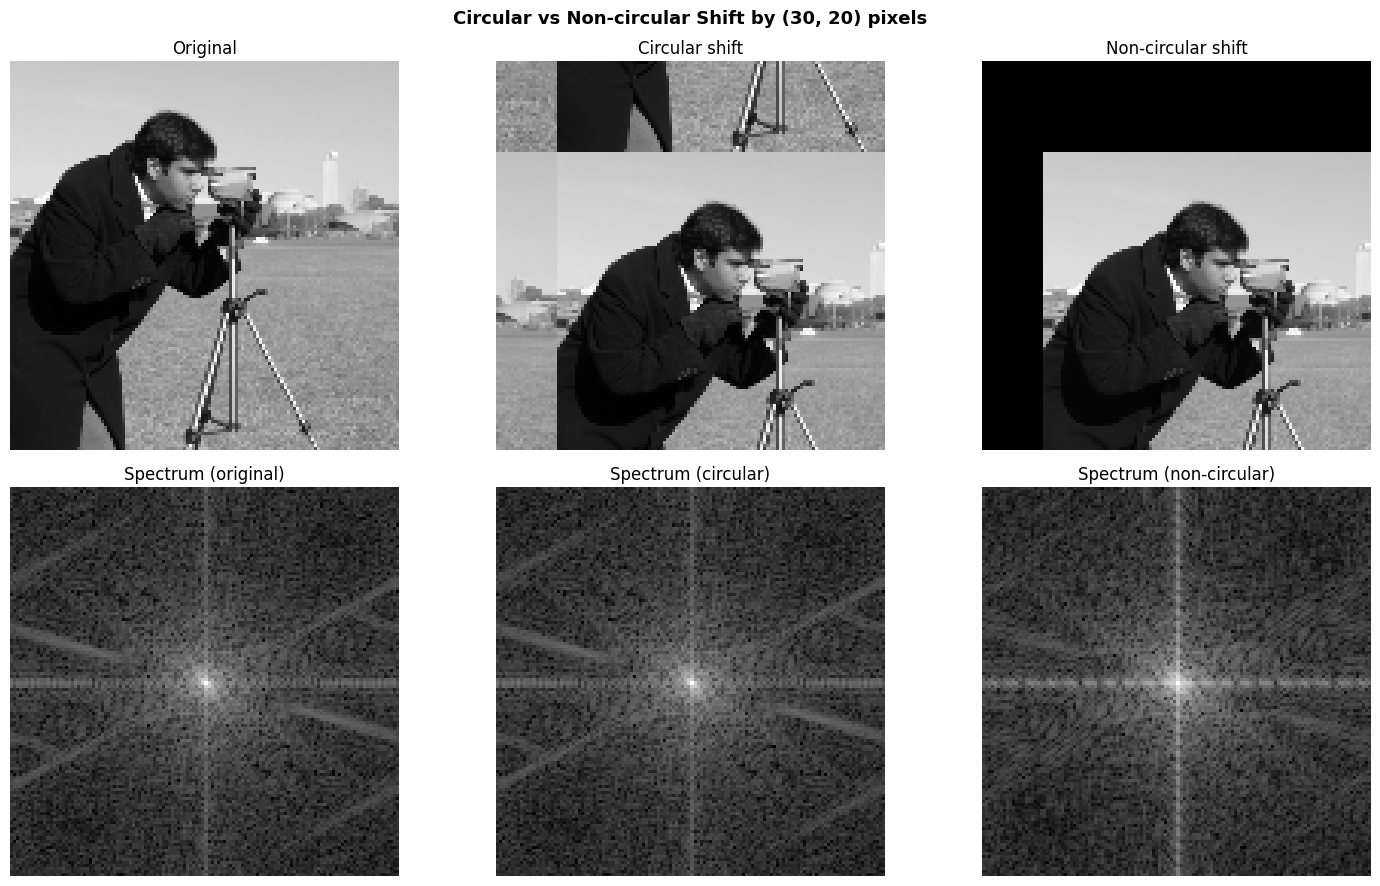

Circular shift    - max magnitude error: 2.27e-13
Non-circular shift - max magnitude error: 3.10e+03


In [13]:
N = PROP_SIZE
dx, dy = 30, 20

# === Circular shift: pixels wrap around ===
cam_circular = np.roll(np.roll(cam_prop, dx, axis=0), dy, axis=1)

# === Non-circular shift: pixels that leave are lost, replaced by zeros ===
cam_noncircular = np.zeros_like(cam_prop)
# only copy the region that stays inside after shifting down by dx, right by dy
cam_noncircular[dx:, dy:] = cam_prop[:N-dx, :N-dy]

# Spectra
mag_orig     = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(cam_prop))))
mag_circular = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(cam_circular))))
mag_noncirc  = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(cam_noncircular))))

fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# Top row: spatial images
axes[0,0].imshow(cam_prop, cmap='gray');        axes[0,0].set_title("Original");           axes[0,0].axis('off')
axes[0,1].imshow(cam_circular, cmap='gray');    axes[0,1].set_title("Circular shift");     axes[0,1].axis('off')
axes[0,2].imshow(cam_noncircular, cmap='gray'); axes[0,2].set_title("Non-circular shift"); axes[0,2].axis('off')

# Bottom row: magnitude spectra
axes[1,0].imshow(mag_orig, cmap='gray');     axes[1,0].set_title("Spectrum (original)");      axes[1,0].axis('off')
axes[1,1].imshow(mag_circular, cmap='gray'); axes[1,1].set_title("Spectrum (circular)");      axes[1,1].axis('off')
axes[1,2].imshow(mag_noncirc, cmap='gray');  axes[1,2].set_title("Spectrum (non-circular)");  axes[1,2].axis('off')

fig.suptitle(f"Circular vs Non-circular Shift by ({dx}, {dy}) pixels", fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

err_circ    = np.max(np.abs(np.abs(np.fft.fft2(cam_prop)) - np.abs(np.fft.fft2(cam_circular))))
err_noncirc = np.max(np.abs(np.abs(np.fft.fft2(cam_prop)) - np.abs(np.fft.fft2(cam_noncircular))))
print(f"Circular shift    - max magnitude error: {err_circ:.2e}")
print(f"Non-circular shift - max magnitude error: {err_noncirc:.2e}")

### 4. Rotation

Rotating an image by angle $\theta$ in the spatial domain rotates its Fourier transform by the **same angle** $\theta$:

$$f(r, \phi + \theta) \;\longleftrightarrow\; F(\rho, \psi + \theta)$$

where $(r, \phi)$ and $(\rho, \psi)$ are polar coordinates in the spatial and frequency domains respectively.

We use a horizontal bar and rotate it by 45°.

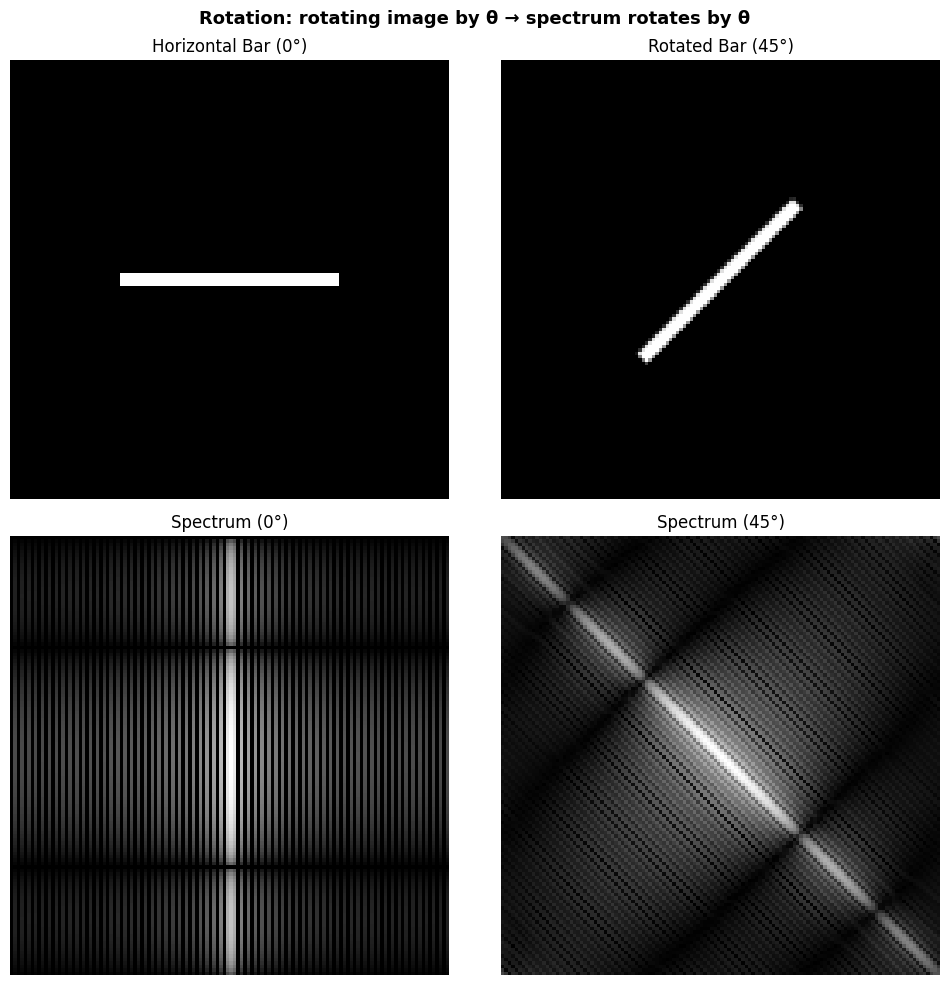

In [14]:
N = PROP_SIZE

# Horizontal bright bar
bar = np.zeros((N, N))
bar[N//2 - 2 : N//2 + 2, N//4 : 3*N//4] = 1.0

# Rotate by 45° using OpenCV
center = (N // 2, N // 2)
M_rot = cv2.getRotationMatrix2D(center, 45, 1.0)
bar_rot = cv2.warpAffine(bar.astype(np.float32), M_rot, (N, N)).astype(np.float64)

F_bar     = np.fft.fftshift(np.fft.fft2(bar))
F_bar_rot = np.fft.fftshift(np.fft.fft2(bar_rot))

mag_bar     = np.log1p(np.abs(F_bar))
mag_bar_rot = np.log1p(np.abs(F_bar_rot))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(bar, cmap='gray');     axes[0,0].set_title("Horizontal Bar (0°)"); axes[0,0].axis('off')
axes[0,1].imshow(bar_rot, cmap='gray'); axes[0,1].set_title("Rotated Bar (45°)"); axes[0,1].axis('off')

axes[1,0].imshow(mag_bar, cmap='gray');     axes[1,0].set_title("Spectrum (0°)"); axes[1,0].axis('off')
axes[1,1].imshow(mag_bar_rot, cmap='gray'); axes[1,1].set_title("Spectrum (45°)"); axes[1,1].axis('off')

fig.suptitle("Rotation: rotating image by θ → spectrum rotates by θ", fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

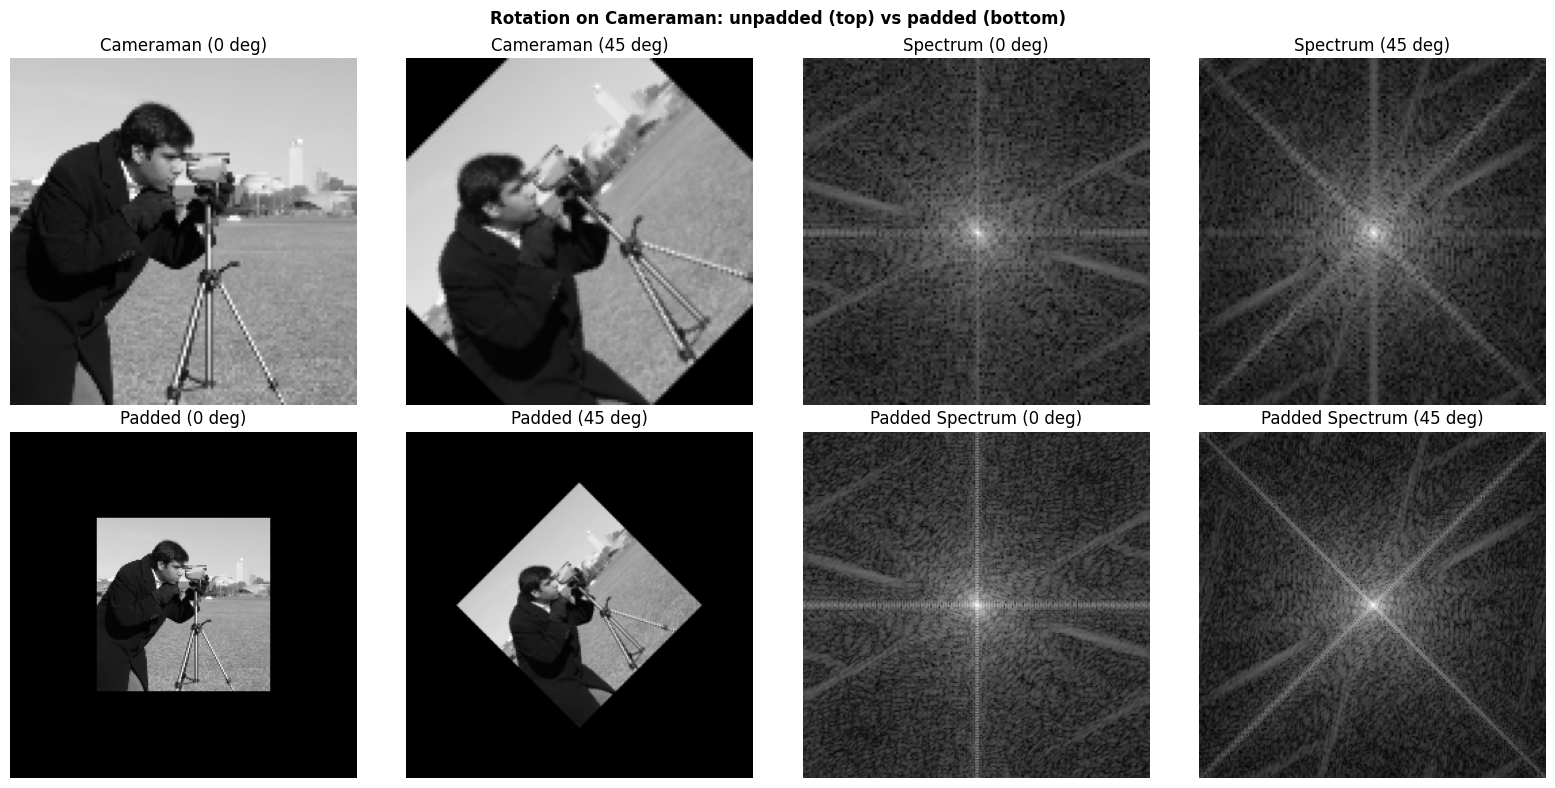

In [15]:
# Rotation on cameraman
center = (PROP_SIZE // 2, PROP_SIZE // 2)
M_rot = cv2.getRotationMatrix2D(center, 45, 1.0)
cam_rot = cv2.warpAffine(cam_prop.astype(np.float32), M_rot, (PROP_SIZE, PROP_SIZE)).astype(np.float64)

mag_cam = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(cam_prop))))
mag_cam_rot = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(cam_rot))))

# --- Padded version: embed in larger canvas so rotation doesn't clip ---
pad = PROP_SIZE // 2
N_big = PROP_SIZE + 2 * pad
cam_big = np.zeros((N_big, N_big))
cam_big[pad:pad+PROP_SIZE, pad:pad+PROP_SIZE] = cam_prop

center_big = (N_big // 2, N_big // 2)
M_rot_big = cv2.getRotationMatrix2D(center_big, 45, 1.0)
cam_big_rot = cv2.warpAffine(cam_big.astype(np.float32), M_rot_big, (N_big, N_big)).astype(np.float64)

mag_big = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(cam_big))))
mag_big_rot = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(cam_big_rot))))

# --- Plot: top row = original size, bottom row = padded ---
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0,0].imshow(cam_prop, cmap='gray'); axes[0,0].set_title("Cameraman (0 deg)"); axes[0,0].axis('off')
axes[0,1].imshow(cam_rot, cmap='gray'); axes[0,1].set_title("Cameraman (45 deg)"); axes[0,1].axis('off')
axes[0,2].imshow(mag_cam, cmap='gray'); axes[0,2].set_title("Spectrum (0 deg)"); axes[0,2].axis('off')
axes[0,3].imshow(mag_cam_rot, cmap='gray'); axes[0,3].set_title("Spectrum (45 deg)"); axes[0,3].axis('off')

axes[1,0].imshow(cam_big, cmap='gray'); axes[1,0].set_title("Padded (0 deg)"); axes[1,0].axis('off')
axes[1,1].imshow(cam_big_rot, cmap='gray'); axes[1,1].set_title("Padded (45 deg)"); axes[1,1].axis('off')
axes[1,2].imshow(mag_big, cmap='gray'); axes[1,2].set_title("Padded Spectrum (0 deg)"); axes[1,2].axis('off')
axes[1,3].imshow(mag_big_rot, cmap='gray'); axes[1,3].set_title("Padded Spectrum (45 deg)"); axes[1,3].axis('off')

fig.suptitle("Rotation on Cameraman: unpadded (top) vs padded (bottom)", fontsize=12, fontweight='bold')
plt.tight_layout(); plt.show()

### How is the Rotation Property useful in practice?

Rotating an image by $\theta$ rotates its magnitude spectrum by the same $\theta$. People exploit this in two main ways:

**. Finding orientation from the spectrum**

A pattern with a dominant direction (say vertical stripes) concentrates spectral energy along a line perpendicular to that direction. If the pattern is tilted, that spectral line tilts by the same amount. So instead of searching for edges or lines in the pixel domain, you can just look at where the energy sits in the spectrum.

*Concrete use:* A scanned document with slightly tilted text has strong horizontal periodicity (text lines). In the spectrum, this shows up as a bright line. Measuring the tilt of that line gives you the deskew angle directly.





### Inherent Periodicity of the DFT

**Periodicity from the basis functions**

The DFT basis $e_k[n] = e^{j2\pi kn/N}$ satisfies $e_k[n + N] = e_k[n]$ because $e^{j2\pi k} = 1$ for integer $k$. Since the inverse DFT reconstructs a signal as a sum of these basis functions:

$$
f[n] = \frac{1}{N} \sum_{k=0}^{N-1} F[k] \; e^{j2\pi kn/N}
$$

the result is periodic with period $N$:

$$
f[n + N] = f[n] \quad \text{for all } n \in \mathbb{Z}
$$

The DFT can only represent periodic signals. Given $N$ samples, it treats them as one period of an infinite repetition:

$$
\ldots,\; \underbrace{f[0], \ldots, f[N{-}1]}_{\text{period}},\; \underbrace{f[0], \ldots, f[N{-}1]}_{\text{period}},\; \ldots
$$

**What happens when we naively truncate**

Suppose the true signal is a cosine with frequency $k_0$: $f[n] = \cos(2\pi k_0 n / N)$. We observe only $n = 0, \ldots, N{-}1$.

The periodic extension glues $f[N{-}1]$ to $f[0]$. This is seamless only if:

$$
f[N{-}1] \approx f[-1] \quad \Longleftrightarrow \quad \cos\!\left(\frac{2\pi k_0 (N{-}1)}{N}\right) \approx \cos\!\left(\frac{-2\pi k_0}{N}\right)
$$

which holds when $k_0 \in \mathbb{Z}$ (exactly an integer number of cycles fit in $N$ samples).

When $k_0 \notin \mathbb{Z}$, the signal is mid-cycle at the truncation boundary. The periodic extension creates a step discontinuity at every junction:

$$
\text{jump} = f[0] - f[N{-}1] \neq 0
$$

This discontinuity is a sharp edge, and the DFT represents sharp edges with energy across all frequency bins (spectral leakage). The code cell below shows this for $k_0 = 3$ (seamless) vs. $k_0 = 3.4$ (discontinuity).

In 2D, the same happens independently along both axes. A real image almost never matches at opposite borders, so the 2D periodic extension always has seams, which is why windowing or padding is needed before spectral analysis.

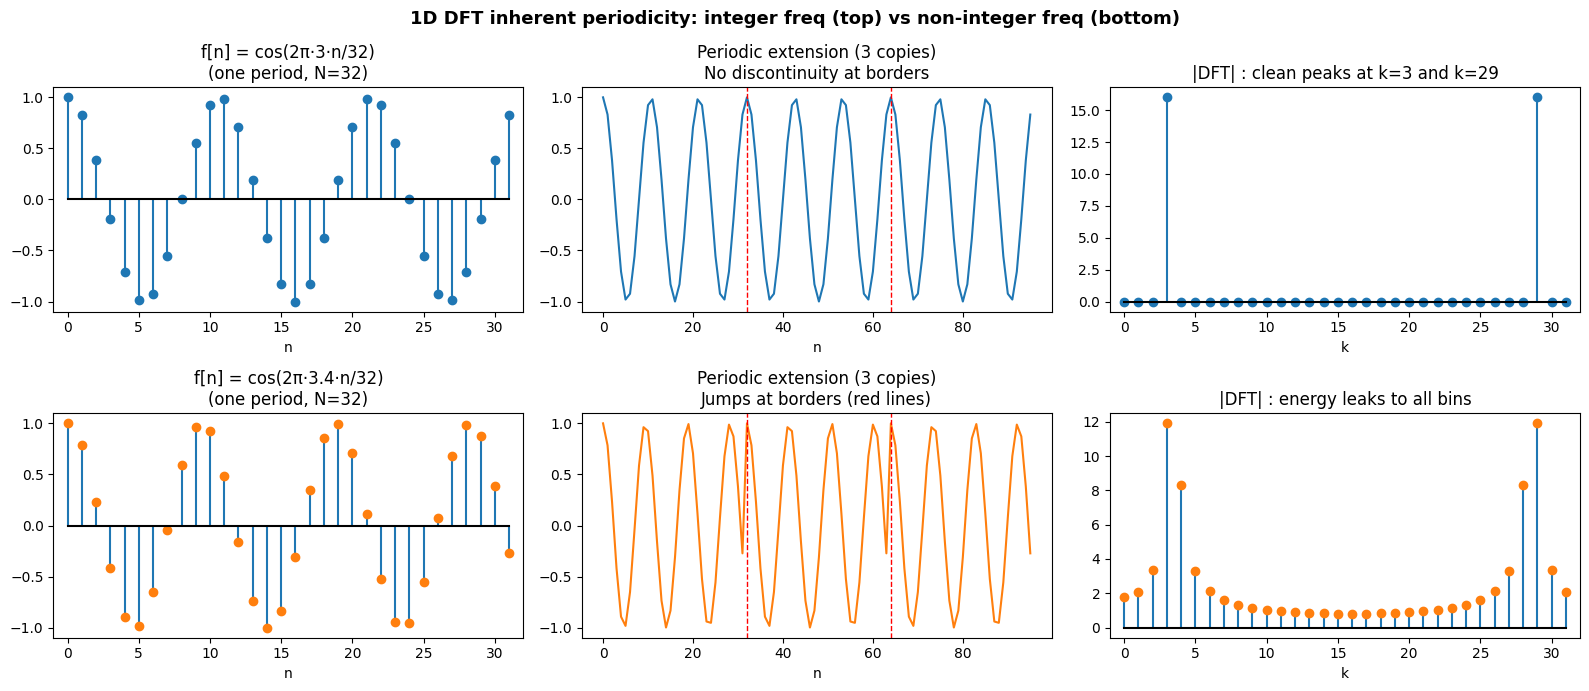

Aligned:    f[0] = 1.0000,  f[N-1] = 0.8315,  f[N] would be f[0] = 1.0000  => jump = 0.1685
Misaligned: f[0] = 1.0000,  f[N-1] = -0.2714,  f[N] would be f[0] = 1.0000  => jump = 1.2714


In [16]:
N = 32

# --- Signal 1: integer frequency (k=3) => completes exactly 3 cycles in N samples ---
n = np.arange(N)
f_aligned = np.cos(2 * np.pi * 3 * n / N)

# --- Signal 2: non-integer frequency (k=3.4) => does NOT complete full cycles ---
f_misaligned = np.cos(2 * np.pi * 3.4 * n / N)

# IDFT reconstructs a periodic signal: tile 3 copies to show the periodic extension
f_aligned_tiled = np.tile(f_aligned, 3)
f_misaligned_tiled = np.tile(f_misaligned, 3)
n_tiled = np.arange(3 * N)

# DFT magnitudes
mag_aligned = np.abs(np.fft.fft(f_aligned))
mag_misaligned = np.abs(np.fft.fft(f_misaligned))
freqs = np.arange(N)

fig, axes = plt.subplots(2, 3, figsize=(16, 7))

# Top row: aligned (integer frequency)
axes[0,0].stem(n, f_aligned, markerfmt='C0o', basefmt='k-')
axes[0,0].set_title("f[n] = cos(2π·3·n/32)\n(one period, N=32)")
axes[0,0].set_xlabel("n"); axes[0,0].set_xlim(-1, N)

axes[0,1].plot(n_tiled, f_aligned_tiled, 'C0-')
for i in range(1, 3):
    axes[0,1].axvline(i * N, color='red', linestyle='--', linewidth=1)
axes[0,1].set_title("Periodic extension (3 copies)\nNo discontinuity at borders")
axes[0,1].set_xlabel("n")

axes[0,2].stem(freqs, mag_aligned, markerfmt='C0o', basefmt='k-')
axes[0,2].set_title("|DFT| : clean peaks at k=3 and k=29")
axes[0,2].set_xlabel("k"); axes[0,2].set_xlim(-1, N)

# Bottom row: misaligned (non-integer frequency)
axes[1,0].stem(n, f_misaligned, markerfmt='C1o', basefmt='k-')
axes[1,0].set_title("f[n] = cos(2π·3.4·n/32)\n(one period, N=32)")
axes[1,0].set_xlabel("n"); axes[1,0].set_xlim(-1, N)

axes[1,1].plot(n_tiled, f_misaligned_tiled, 'C1-')
for i in range(1, 3):
    axes[1,1].axvline(i * N, color='red', linestyle='--', linewidth=1)
axes[1,1].set_title("Periodic extension (3 copies)\nJumps at borders (red lines)")
axes[1,1].set_xlabel("n")

axes[1,2].stem(freqs, mag_misaligned, markerfmt='C1o', basefmt='k-')
axes[1,2].set_title("|DFT| : energy leaks to all bins")
axes[1,2].set_xlabel("k"); axes[1,2].set_xlim(-1, N)

fig.suptitle("1D DFT inherent periodicity: integer freq (top) vs non-integer freq (bottom)",
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

# Print the border values
print(f"Aligned:    f[0] = {f_aligned[0]:.4f},  f[N-1] = {f_aligned[-1]:.4f},  f[N] would be f[0] = {f_aligned[0]:.4f}  => jump = {abs(f_aligned[-1] - f_aligned[0]):.4f}")
print(f"Misaligned: f[0] = {f_misaligned[0]:.4f},  f[N-1] = {f_misaligned[-1]:.4f},  f[N] would be f[0] = {f_misaligned[0]:.4f}  => jump = {abs(f_misaligned[-1] - f_misaligned[0]):.4f}")

### Edge Effects and Windowing

The DFT of a finite $N \times N$ image $f[x, y]$ implicitly treats it as **one period** of an infinite periodic signal:

$$
\tilde{f}[x, y] = f[x \bmod N,\; y \bmod N]
$$

This periodic extension tiles copies of the image edge-to-edge in all directions.

**When does this cause problems?**

Consider a 2D cosine $f[x,y] = \cos\!\left(2\pi\left(\frac{k_x x}{N} + \frac{k_y y}{N}\right)\right)$.

- **Integer frequencies** ($k_x, k_y \in \mathbb{Z}$): The cosine completes exactly an integer number of cycles over $N$ samples. The value at $x = N$ equals the value at $x = 0$, so the periodic extension is seamless:

$$
f[0, y] = f[N, y] \quad \Longrightarrow \quad \text{no discontinuity at tile boundaries}
$$

The DFT is a pair of delta peaks at $\pm(k_x, k_y)$, exactly as expected.

- **Non-integer frequencies** ($k_x, k_y \notin \mathbb{Z}$): The cosine does **not** complete a full cycle. The left and right borders have different values:

$$
f[0, y] \neq f[N, y] \quad \Longrightarrow \quad \text{a step discontinuity at every tile boundary}
$$

A step discontinuity is a sharp edge, and a sharp edge has energy across **all** frequencies. This extra energy "leaks" from the true frequency into neighboring bins, an artifact called **spectral leakage**. In the 2D FFT, this shows up as streaks or a broad haze instead of clean peaks.


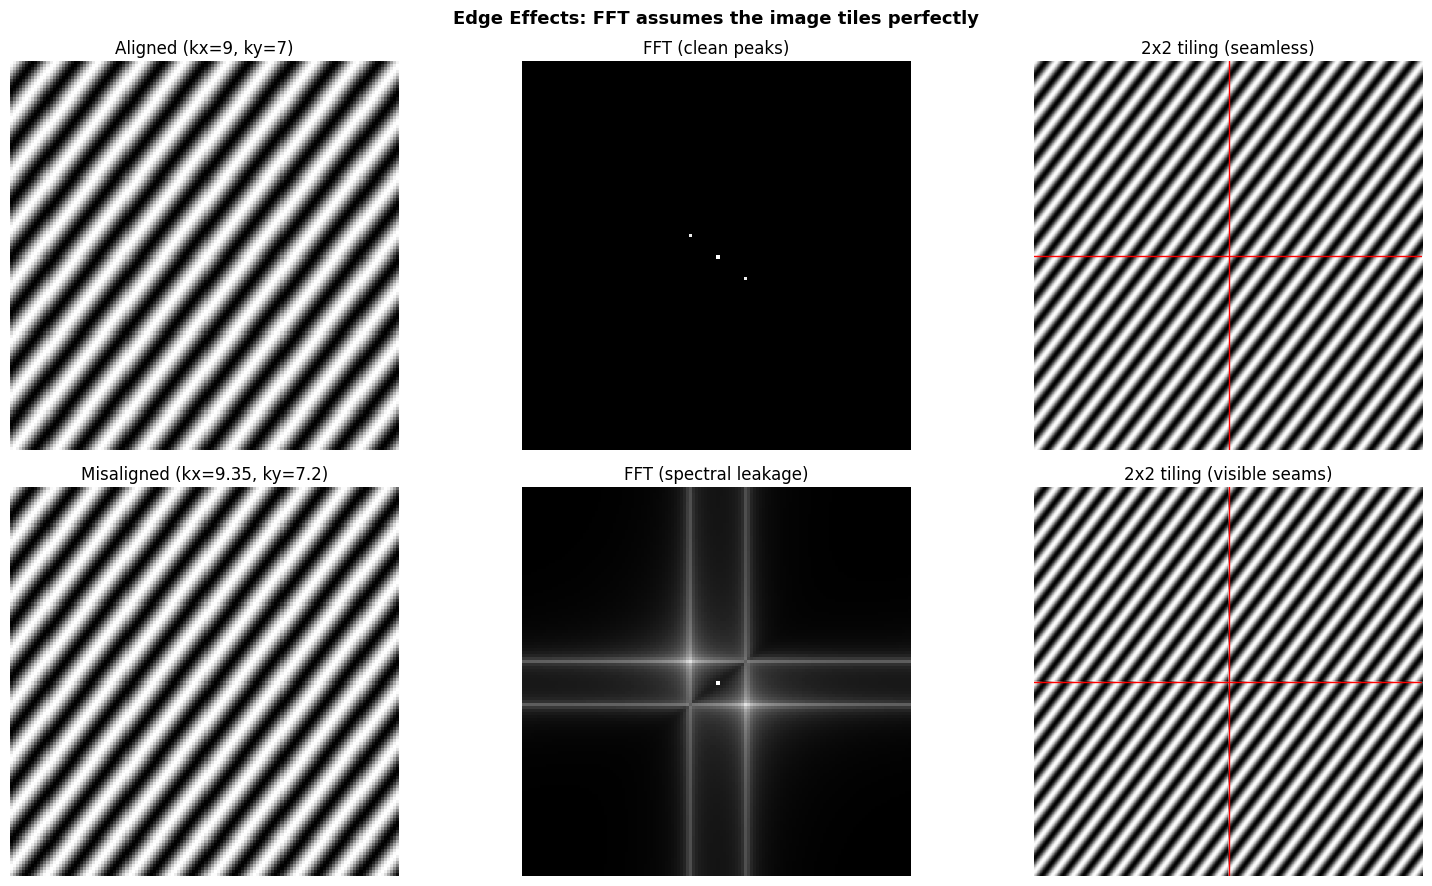

In [17]:
N = 128
x = np.arange(N)
X, Y = np.meshgrid(x, x)

# --- Aligned (integer frequencies): perfectly periodic on NxN grid ---
kx_good, ky_good = 9, 7
tile_good = 0.5 + 0.5 * np.cos(2*np.pi*(kx_good*X/N + ky_good*Y/N))

# --- Misaligned (non-integer frequencies): edges don't match ---
kx_bad, ky_bad = 9.35, 7.20
tile_bad = 0.5 + 0.5 * np.cos(2*np.pi*(kx_bad*X/N + ky_bad*Y/N))

# FFTs
mag_good = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(tile_good))))
mag_bad  = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(tile_bad))))

# ========== PART 1: Image vs FFT, then tiling to reveal seams ==========
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# Row 0: single tiles and their FFTs
axes[0,0].imshow(tile_good, cmap='gray', vmin=0, vmax=1)
axes[0,0].set_title(f"Aligned (kx={kx_good}, ky={ky_good})"); axes[0,0].axis('off')

axes[0,1].imshow(mag_good, cmap='gray')
axes[0,1].set_title("FFT (clean peaks)"); axes[0,1].axis('off')

axes[0,2].imshow(np.tile(tile_good, (2, 2)), cmap='gray', vmin=0, vmax=1)
axes[0,2].set_title("2x2 tiling (seamless)"); axes[0,2].axis('off')
# draw border lines to highlight tile boundaries
axes[0,2].axhline(N, color='red', linewidth=1)
axes[0,2].axvline(N, color='red', linewidth=1)

# Row 1: misaligned
axes[1,0].imshow(tile_bad, cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title(f"Misaligned (kx={kx_bad}, ky={ky_bad})"); axes[1,0].axis('off')

axes[1,1].imshow(mag_bad, cmap='gray')
axes[1,1].set_title("FFT (spectral leakage)"); axes[1,1].axis('off')

axes[1,2].imshow(np.tile(tile_bad, (2, 2)), cmap='gray', vmin=0, vmax=1)
axes[1,2].set_title("2x2 tiling (visible seams)"); axes[1,2].axis('off')
axes[1,2].axhline(N, color='red', linewidth=1)
axes[1,2].axvline(N, color='red', linewidth=1)

fig.suptitle("Edge Effects: FFT assumes the image tiles perfectly", fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

Because $k_x = 9$ is an **integer**, and the cosine is defined as:

$$
f[x, y] = \cos\!\left(2\pi\left(\frac{k_x \cdot x}{N} + \frac{k_y \cdot y}{N}\right)\right)
$$

with $N = 128$.

$$
f[N, y] = \cos\!\left(2\pi\left(\frac{9 \cdot 128}{128} + \frac{7 \cdot y}{128}\right)\right) = \cos\!\left(2\pi\left(9 + \frac{7y}{128}\right)\right)
$$

Since $\cos(2\pi \cdot 9 + \theta) = \cos(\theta)$ (cosine is periodic with period $2\pi$, and $2\pi \cdot 9$ is an integer multiple of $2\pi$):

$$
f[N, y] = \cos\!\left(2\pi\cdot\frac{7y}{128}\right) = f[0, y] \quad \checkmark
$$

The signal completes **exactly 9 full cycles** across 128 samples. Sample $N$ lands right back where sample $0$ started, so the periodic extension is seamless.

For $k_x = 9.35$:

$$
f[N, y] = \cos\!\left(2\pi\left(9.35 + \frac{7.2 \cdot y}{128}\right)\right) \neq f[0, y]
$$

because $\cos(2\pi \cdot 9.35 + \theta) \neq \cos(\theta)$ — the extra $0.35$ of a cycle means the signal hasn't returned to its starting value. That leftover fraction creates the mismatch at the border.


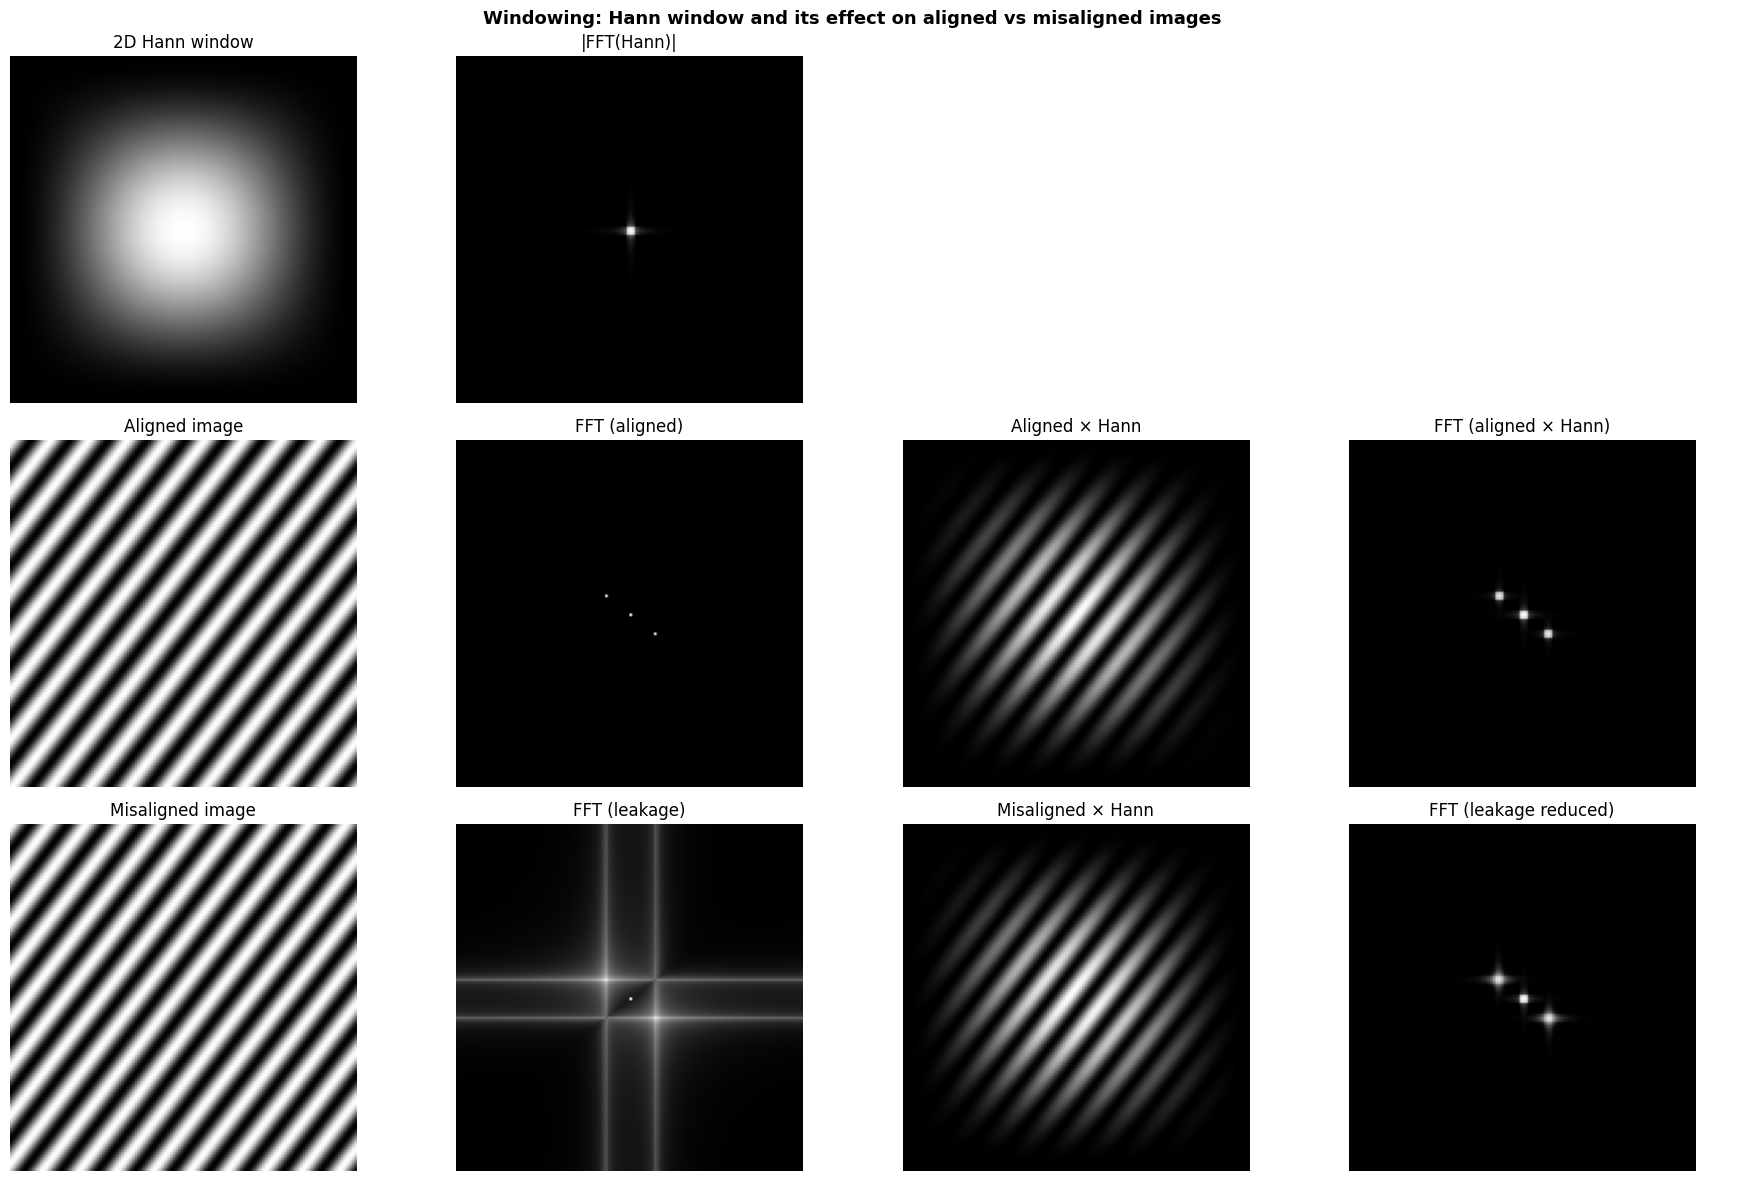

In [18]:
N = 128
x = np.arange(N)
X, Y = np.meshgrid(x, x)

# Aligned and misaligned cosines (from earlier)
kx_good, ky_good = 9, 7
tile_good = 0.5 + 0.5 * np.cos(2*np.pi*(kx_good*X/N + ky_good*Y/N))

kx_bad, ky_bad = 9.35, 7.20
tile_bad = 0.5 + 0.5 * np.cos(2*np.pi*(kx_bad*X/N + ky_bad*Y/N))

# 2D Hann window
w = np.hanning(N)
W2 = np.outer(w, w)

# Windowed images
tile_good_win = tile_good * W2
tile_bad_win  = tile_bad * W2

# FFTs
mag_hann     = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(W2))))
mag_good     = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(tile_good))))
mag_bad      = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(tile_bad))))
mag_good_win = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(tile_good_win))))
mag_bad_win  = np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(tile_bad_win))))

fig, axes = plt.subplots(3, 4, figsize=(18, 12))

# Row 0: 2D Hann window
axes[0,0].imshow(W2, cmap='gray')
axes[0,0].set_title("2D Hann window"); axes[0,0].axis('off')
axes[0,1].imshow(mag_hann, cmap='gray')
axes[0,1].set_title("|FFT(Hann)|"); axes[0,1].axis('off')
axes[0,2].axis('off')
axes[0,3].axis('off')

# Row 1: Aligned image — original vs windowed
axes[1,0].imshow(tile_good, cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title("Aligned image"); axes[1,0].axis('off')
axes[1,1].imshow(mag_good, cmap='gray')
axes[1,1].set_title("FFT (aligned)"); axes[1,1].axis('off')
axes[1,2].imshow(tile_good_win, cmap='gray')
axes[1,2].set_title("Aligned × Hann"); axes[1,2].axis('off')
axes[1,3].imshow(mag_good_win, cmap='gray')
axes[1,3].set_title("FFT (aligned × Hann)"); axes[1,3].axis('off')

# Row 2: Misaligned image — original vs windowed
axes[2,0].imshow(tile_bad, cmap='gray', vmin=0, vmax=1)
axes[2,0].set_title("Misaligned image"); axes[2,0].axis('off')
axes[2,1].imshow(mag_bad, cmap='gray')
axes[2,1].set_title("FFT (leakage)"); axes[2,1].axis('off')
axes[2,2].imshow(tile_bad_win, cmap='gray')
axes[2,2].set_title("Misaligned × Hann"); axes[2,2].axis('off')
axes[2,3].imshow(mag_bad_win, cmap='gray')
axes[2,3].set_title("FFT (leakage reduced)"); axes[2,3].axis('off')

fig.suptitle("Windowing: Hann window and its effect on aligned vs misaligned images",
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

**Why windowing helps:**

A window function $w[n]$ (e.g., the Hann window) tapers smoothly to zero at both ends:

$$
w[n] = 0.5 - 0.5\cos\!\left(\frac{2\pi n}{N}\right), \quad n = 0, \ldots, N-1
$$

The 2D window is the outer product $W[x,y] = w[x] \cdot w[y]$.

Multiplying the image by $W$ before taking the FFT:

$$
f_w[x,y] = f[x,y] \cdot W[x,y]
$$

forces $f_w$ to be zero at all borders. The periodic extension now has **no discontinuity** at tile boundaries (both sides are zero), so the leakage artifacts largely disappear.

The tradeoff: windowing suppresses edge artifacts but also attenuates the signal near the borders and slightly broadens the spectral peaks (reduced frequency resolution). For visualization and spectral analysis this is usually an acceptable trade.

**What the code below demonstrates:**

| | Single tile | 2×2 tiling | FFT |
|---|---|---|---|
| **Aligned** (integer freq) | Cosine with $k_x = 9, k_y = 7$ | Tiles seamlessly | Two clean peaks |
| **Misaligned** (non-integer freq) | Cosine with $k_x = 9.35, k_y = 7.2$ | Visible seams at tile borders | Leakage: energy spread everywhere |
| **Misaligned + Hann window** | Tapered to zero at edges | Borders match (both zero) | Leakage greatly reduced |
### When do edge effects and windowing matter in practice?

Real images almost never tile seamlessly: the left column rarely matches the right, and the top row rarely matches the bottom. So every time you take the FFT of a real image, the periodic extension introduces artificial discontinuities at the borders.

**Example where this causes real problems:**

**Spectral analysis of textures and materials**

When measuring the dominant spatial frequencies in a surface (e.g., fabric weave pitch, semiconductor wafer patterns, wood grain spacing), spectral leakage from border discontinuities adds a broad low-frequency haze that can mask or shift the true peaks. Applying a 2D Hann or Hamming window before the FFT removes this haze and gives accurate frequency measurements.



### 5. Convolution Theorem

**Continuous form:**

$$
(f * g)(x, y) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} f(\tau_1, \tau_2) \; g(x - \tau_1,\; y - \tau_2) \; d\tau_1 \, d\tau_2
$$

$$
\mathcal{F}\{f * g\} = F(u,v) \cdot G(u,v)
$$

And conversely, multiplication in space becomes convolution in frequency:

$$
\mathcal{F}\{f \cdot g\} = F(u,v) * G(u,v)
$$

**Discrete form (what the code computes):**

For $M \times N$ images, circular convolution is:

$$
(f \circledast g)[m, n] = \sum_{k=0}^{M-1} \sum_{l=0}^{N-1} f[k, l] \; g[(m-k) \bmod M,\; (n-l) \bmod N]
$$

and the discrete convolution theorem states:

$$
\text{DFT}\{f \circledast g\} = \text{DFT}\{f\} \cdot \text{DFT}\{g\}
$$

Note: this is **circular** convolution (indices wrap around modulo $M, N$), which is exactly what the DFT's periodic assumption gives. Using `scipy.ndimage.convolve` with `mode='wrap'` matches this circular behavior.

**What the code below demonstrates:**

We convolve a checkerboard image $f$ with a horizontal motion blur kernel $g$ using two equivalent paths:

| Row | Col 1 | Col 2 | Col 3 |
|---|---|---|---|
| **Spatial** | Image $f$ | Kernel $g$ (21×21 motion blur) | $f \circledast g$ (direct convolution) |
| **Frequency** | $\|F\|$ (spectrum of $f$) | $\|G\|$ (spectrum of $g$) | $\text{IFFT}(F \cdot G)$ |

The spatial result (top right) and frequency result (bottom right) should be identical, confirming $f \circledast g = \text{IFFT}(\text{FFT}(f) \cdot \text{FFT}(g))$.

The kernel must be zero-padded to the image size and centered at $(0,0)$ via `np.roll` before taking its FFT, so that both the spatial `convolve` and the frequency multiplication reference the same kernel origin.

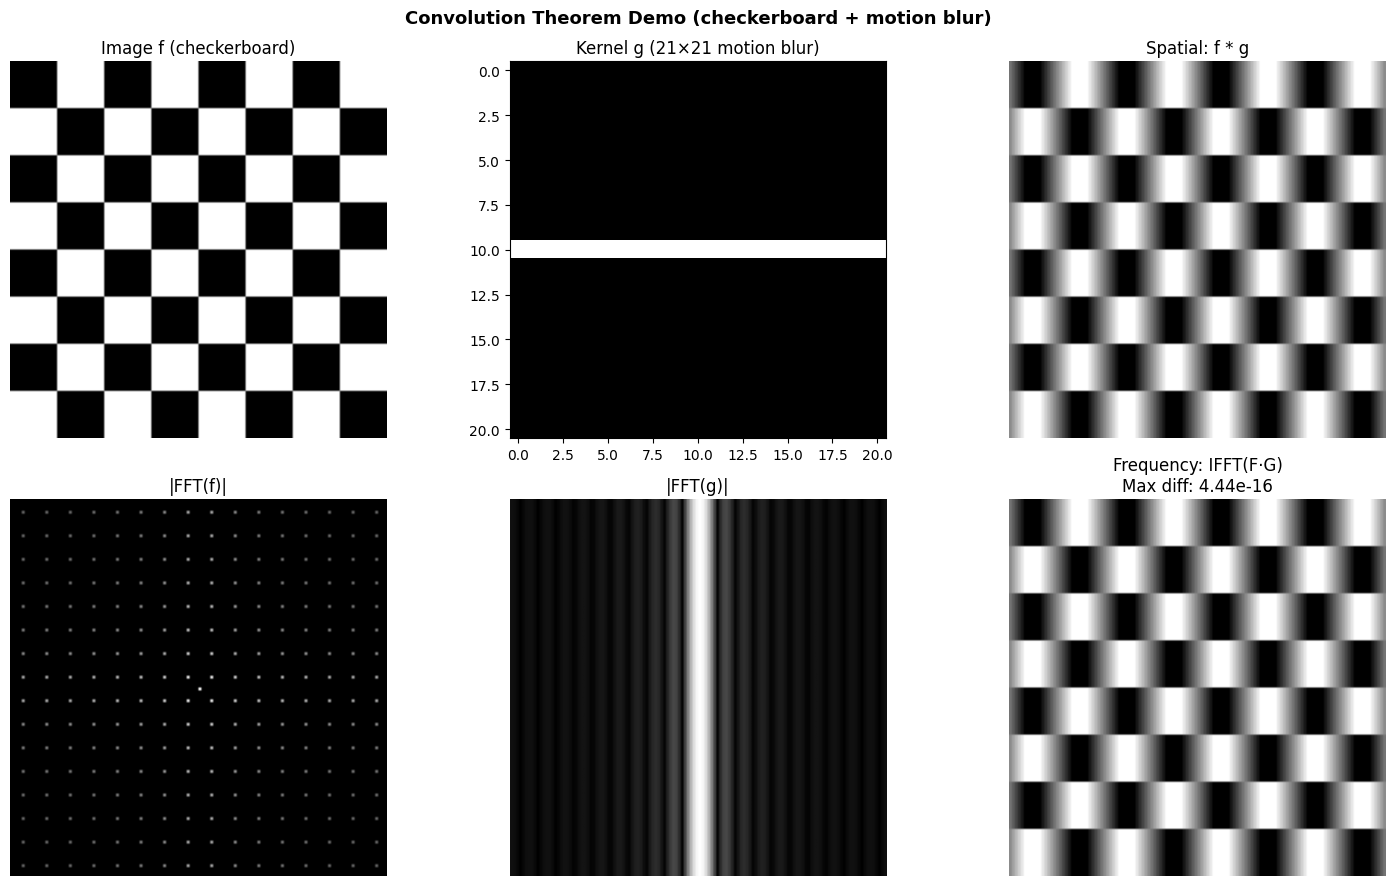

In [19]:
N = 128

# --- Image: checkerboard (rich high-frequency content) ---
sq = N // 8
x = np.arange(N)
X, Y = np.meshgrid(x, x)
img = (((X // sq) + (Y // sq)) % 2).astype(np.float64)


ksize = 21
kernel = np.zeros((ksize, ksize), dtype=np.float64)
kernel[ksize // 2, :] = 1.0
kernel /= kernel.sum()

kernel_padded = np.zeros((N, N), dtype=np.float64)
kernel_padded[:ksize, :ksize] = kernel
half = ksize // 2
kernel_padded = np.roll(np.roll(kernel_padded, -half, axis=0), -half, axis=1)

# === Method 1: spatial convolution (circular) ===
conv_spatial = convolve(img, kernel, mode='wrap')

# === Method 2: frequency-domain multiplication ===
F_img = np.fft.fft2(img)
F_k   = np.fft.fft2(kernel_padded)
conv_freq = np.real(np.fft.ifft2(F_img * F_k))

# Error
err_map = np.abs(conv_spatial - conv_freq)
max_diff = np.max(err_map)


fig, axes = plt.subplots(2, 3, figsize=(15, 9))

axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title("Image f (checkerboard)")
axes[0, 0].axis('off')

axes[0, 1].imshow(kernel, cmap='gray', interpolation='nearest')
axes[0, 1].set_title(f"Kernel g ({ksize}×{ksize} motion blur)")


axes[0, 2].imshow(conv_spatial, cmap='gray')
axes[0, 2].set_title("Spatial: f * g")
axes[0, 2].axis('off')

axes[1, 0].imshow(np.log1p(np.abs(np.fft.fftshift(F_img))), cmap='gray')
axes[1, 0].set_title("|FFT(f)|")
axes[1, 0].axis('off')

axes[1, 1].imshow(np.log1p(np.abs(np.fft.fftshift(F_k))), cmap='gray')
axes[1, 1].set_title("|FFT(g)|")
axes[1, 1].axis('off')

axes[1, 2].imshow(conv_freq, cmap='gray')
axes[1, 2].set_title(f"Frequency: IFFT(F·G)\nMax diff: {max_diff:.2e}")
axes[1, 2].axis('off')

fig.suptitle("Convolution Theorem Demo (checkerboard + motion blur)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()



### Boundary Handling in Convolution

When a kernel overlaps the edge of an image, some kernel positions fall outside the image. The boundary mode decides what value to use for these missing pixels.

Consider a 1D signal `[a, b, c, d]` and a kernel that needs one neighbor on each side. At the left edge, position `a` needs a pixel to its left that doesn't exist. Each mode fills it differently:

**`wrap` (circular)**

The signal is treated as periodic. Pixels that fall off one side reappear on the other:

$$\ldots\; d \;|\; a \; b \; c \; d \;|\; a \;\ldots$$

This matches the DFT's inherent assumption. FFT-based convolution always produces circular convolution.

**`reflect` (mirror)**

The signal is reflected at the boundary:

$$\ldots\; b \;|\; a \; b \; c \; d \;|\; c \;\ldots$$

The edge pixel is not repeated. This avoids introducing discontinuities and is the default in most image processing libraries (e.g., OpenCV `cv2.filter2D`).

**`nearest` (replicate)**

The edge pixel is repeated as many times as needed:

$$\ldots\; a \;|\; a \; b \; c \; d \;|\; d \;\ldots$$

Simple but can create visible plateau artifacts near borders.

**`constant` (zero-pad)**

Pixels outside the image are set to a fixed value (usually 0):

$$\ldots\; 0 \;|\; a \; b \; c \; d \;|\; 0 \;\ldots$$

This darkens the edges since the kernel averages real pixels with zeros. Common in signal processing but usually avoided for images.


**When does the choice matter?**

- **Gaussian blurring near borders:** Using zero-pad creates dark edges because the blur averages real pixels with zeros. Reflect mode avoids this.
- **Edge detection (Sobel, Canny):** A zero-padded boundary creates a false strong edge along the image border since there is a sharp jump from image values to zero.
- **FFT-based deconvolution / filtering:** FFT always does circular convolution. If the left edge of the image is bright and the right edge is dark, circular wrapping causes bright content to "leak" into the dark side. Padding with reflection before the FFT prevents this.
- **Tiled processing:** When processing large images in overlapping tiles, each tile boundary is an artificial edge. Using reflect or overlap-and-add avoids seam artifacts between tiles.


**Excercise:**

For each mode:
1. Show the full blurred image.
2. Crop and zoom into a **corner region** (e.g., top-left 60×60 pixels) to clearly see how each mode handles the border.

**Questions to answer:**

1. Which mode produces **dark edges**? Why?
2. Which mode produces the **smoothest transition** at the border? Why does this help for edge detection?
3. Which mode matches FFT-based convolution exactly? Verify by computing `IFFT(FFT(f) * FFT(g_padded))` and checking the max difference against each mode.
4. Try replacing the Gaussian with a **Sobel kernel** (`[[-1,0,1],[-2,0,2],[-1,0,1]]`). Which boundary mode creates a **false edge** along the image border? Which does not?

In [20]:
# questions answered after the code cells below

In [21]:
from scipy.ndimage import convolve, gaussian_filter

# Gaussian kernel
def gaussian_kernel(size=9, sigma=2):
    ax = np.arange(-size//2 + 1., size//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
    return kernel / np.sum(kernel)

g = gaussian_kernel(3, 1)

modes = ["constant", "nearest", "reflect", "wrap"]
img = cv2.imread("cameraman.jpeg", cv2.IMREAD_GRAYSCALE) / 255.0
# img = (((X // sq) + (Y // sq)) % 2).astype(np.float64)


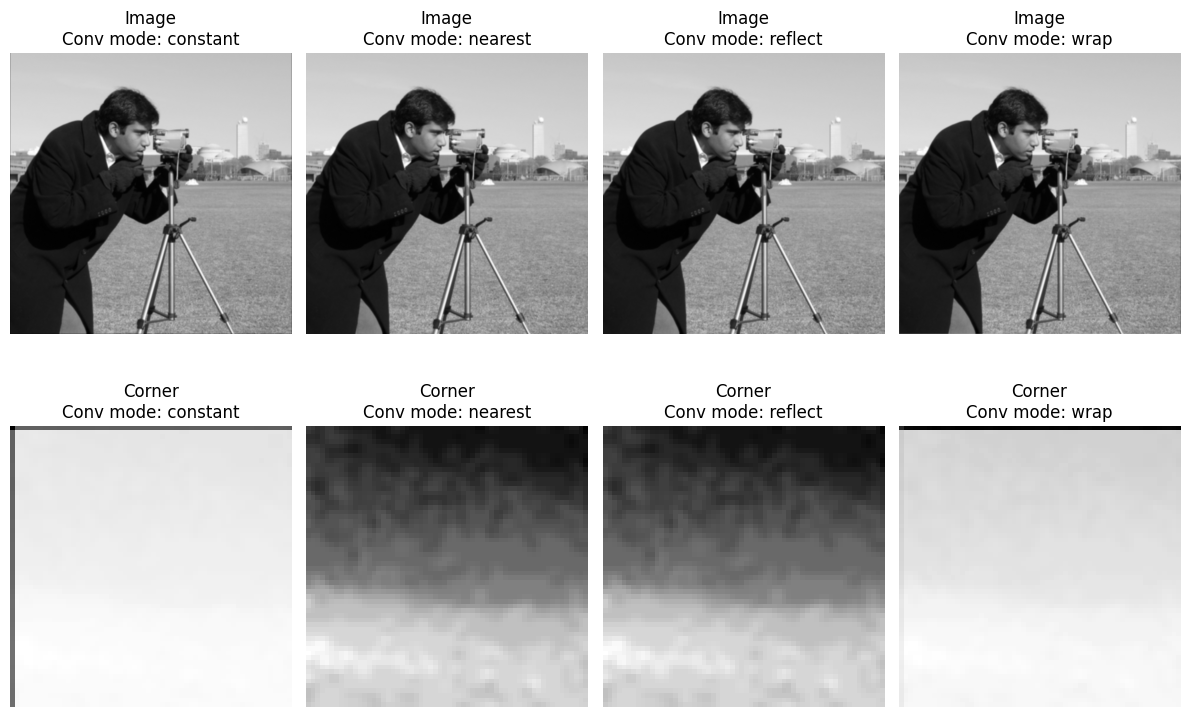

In [22]:
fig, axes = plt.subplots(2, len(modes), figsize=(12, 8))

for i, mode in enumerate(modes):
    blurred = convolve(img, g, mode=mode)

    # Full image
    axes[0,i].imshow(blurred, cmap='gray')
    axes[0,i].set_title(f"Image\nConv mode: {mode}")
    axes[0,i].axis('off')

    # Corner crop
    crop = blurred[:60, :60]
    axes[1,i].imshow(crop, cmap='gray')
    axes[1,i].set_title(f"Corner\nConv mode: {mode}")
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()


Q1: Which mode produces **dark edges**? Why?  
Answer: `"constant"`  
Because:  
* Pixels outside image are assumed to be **0**
* Gaussian averages real pixels with zeros
* This reduces intensity near borders

Mathematically:
$$
f_{blurred}(x) = \sum f(x-k)g(k)
$$
Near boundary, some ($f(x-k) = 0$) due to which sum decreases, and we get darker edge.

---  


Q2: Which mode produces the smoothest transition?  
Answer: `"reflect"`  

As reflect mirrors the image:

```
| A B C D | → | C B A | A B C D | D C B |
```

This preserves:

* Intensity continuity
* First derivative continuity

That means:

* No artificial intensity drop
* No artificial gradient spike

This helps edge detection since, edge detection computes gradients.

If boundary creates fake intensity jump, edge detector (eg, Sobel) detects a false edge.

Reflect keeps gradient near border small, thus avoids false positives.


---  

In [23]:
# for Q3.
modes = ["constant", "nearest", "reflect", "wrap"]
patch = img[:60, :60]
ph, pw = patch.shape
kh, kw = g.shape

# pad the kernel to the patch size
kernel_padded = np.zeros_like(patch)
kernel_padded[:kh, :kw] = g

# shift the kernel so its center is at index (0,0)
# the center of a (kh, kw) kernel is at (kh//2, kw//2)
# we roll the array backwards by these amounts to move the center to the origin
shift_h = -(kh // 2)
shift_w = -(kw // 2)
kernel_fft_ready = np.roll(kernel_padded, shift=(shift_h, shift_w), axis=(0, 1))

# FFT Convolution
F = np.fft.fft2(patch)
G = np.fft.fft2(kernel_fft_ready)

fft_conv = np.real(np.fft.ifft2(F * G))

print("Difference (max) between spatial modes and FFT convolution:\n")
print(f"{'Mode':<10} | {'Max Difference'}")
print("-" * 30)

for mode in modes:
    spatial = convolve(patch, g, mode=mode)
    diff = np.max(np.abs(spatial - fft_conv))

    print(f"{mode:<10} | {diff:.4e}")


Difference (max) between spatial modes and FFT convolution:

Mode       | Max Difference
------------------------------
constant   | 3.7823e-01
nearest    | 1.2499e-02
reflect    | 1.2499e-02
wrap       | 7.7716e-16


Q3: Which mode matches FFT convolution exactly?

Answer: FFT convolution assumes **periodic boundary conditions**.

That means:

$$
f(x+N) = f(x)
$$

So edges wrap around, implying `"wrap"` mode would give the least difference.

```bash
Difference (max) between spatial modes and FFT convolution:

Mode       | Max Difference
------------------------------
constant   | 3.7823e-01
nearest    | 1.2499e-02
reflect    | 1.2499e-02
wrap       | 7.7716e-16 (minimum)
```

---

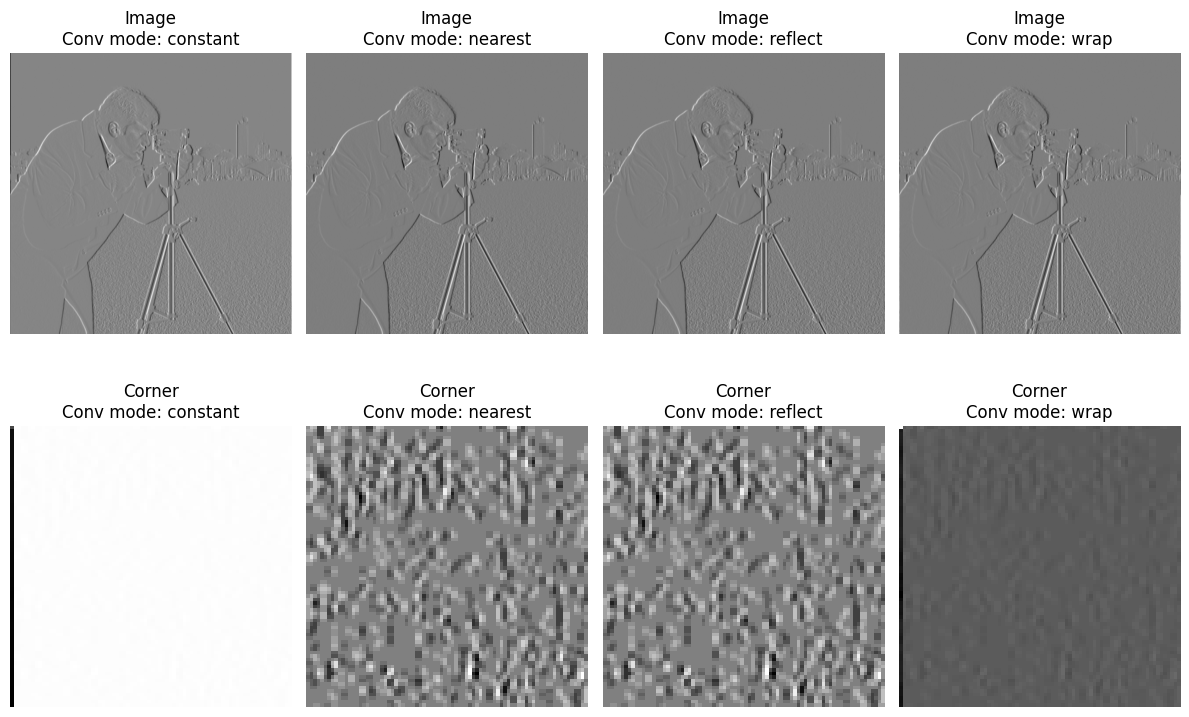

In [24]:
# Q4.
fig, axes = plt.subplots(2, len(modes), figsize=(12, 8))
sobel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
for i, mode in enumerate(modes):
    blurred = convolve(img, sobel, mode=mode)

    # Full image
    axes[0,i].imshow(blurred, cmap='gray')
    axes[0,i].set_title(f"Image\nConv mode: {mode}")
    axes[0,i].axis('off')

    # Corner crop
    crop = blurred[:80, :80]
    axes[1,i].imshow(crop, cmap='gray')
    axes[1,i].set_title(f"Corner\nConv mode: {mode}")
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()


Q4: Try replacing the Gaussian with a Sobel kernel $[[-1,0,1],[-2,0,2],[-1,0,1]]$. Which boundary mode creates a false edge along the image border? Which does not?   
Answer:  `"constant"` and `"wrap"` modes create false edges. Remaining (`"nearest"` and `"reflect"`) do not.  
**Constant**: image meets zeros giving strong gradient so Sobel sees artificial edge.  
**Wrap**: left border compared with right border and usually we have different intensities so we get an artificial edge.

-------------------------------------------------------------------------------------------------------------------------------------------------------------

### 6. Differentiation Property

Taking the **first-order derivative** in the spatial domain corresponds to **multiplication by frequency** in the Fourier domain:

$$\frac{\partial f}{\partial x} \;\longleftrightarrow\; j2\pi u \cdot F(u,v)$$

$$\frac{\partial f}{\partial y} \;\longleftrightarrow\; j2\pi v \cdot F(u,v)$$



In the discrete domain, we approximate the derivative with a finite-difference kernel, for example the central difference $D_x = [-\tfrac{1}{2}, 0, \tfrac{1}{2}]$. Applying this kernel via convolution in the spatial domain is equivalent to multiplying in the frequency domain by the kernel's transfer function:

$$
f * D_x \;\longleftrightarrow\; F(u,v) \cdot H_{D_x}(u)
$$

where $H_{D_x} = \text{FFT}(D_x)$ is the frequency response of the central-difference kernel. For central difference, this is $H_{D_x}(u) = j\sin(2\pi u)$, which approximates the continuous $j2\pi u$ at low frequencies.

We demonstrate this on a simple Gaussian blob: the spatial path (convolve with $D_x$) and the frequency path (multiply by $H_{D_x}$, then IFFT) produce identical results.

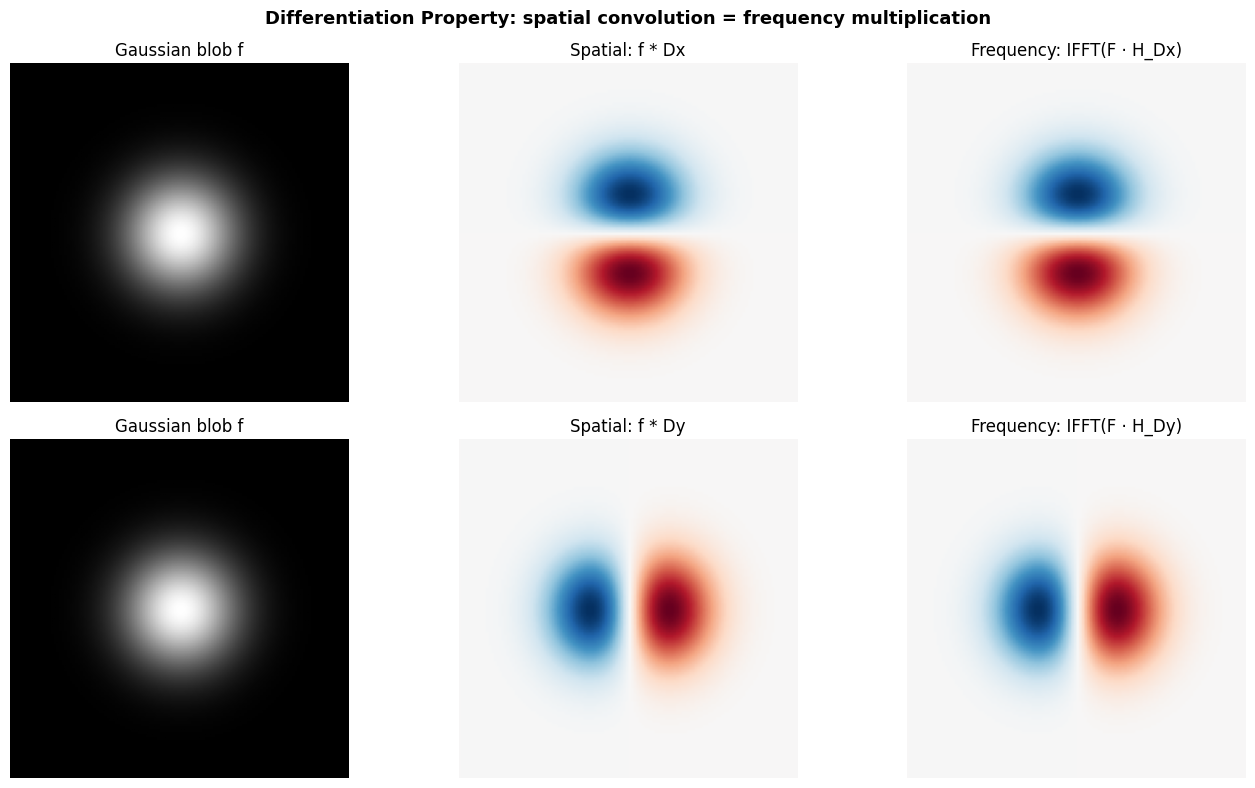

∂f/∂x  max diff (spatial vs freq): 1.37e-16
∂f/∂y  max diff (spatial vs freq): 1.30e-16


In [25]:
N = 128
x = np.arange(N)
X, Y = np.meshgrid(x, x)

# Simple test image: Gaussian blob centered in the image
sigma = 15
gauss = np.exp(-((X - N//2)**2 + (Y - N//2)**2) / (2 * sigma**2))

# --- Derivative kernels ---
Dx = np.array([[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]])  # ∂/∂y (column direction)
Dy = np.array([[0, -0.5, 0], [0, 0, 0], [0, 0.5, 0]])   # ∂/∂x (row direction)

# === Path 1: Spatial convolution ===
df_dx_spatial = convolve(gauss, Dy, mode='wrap')
df_dy_spatial = convolve(gauss, Dx, mode='wrap')

# === Path 2: Frequency multiplication ===
F = np.fft.fft2(gauss)

# Zero-pad kernel to NxN and take its FFT = transfer function H
Dy_padded = np.zeros((N, N)); Dy_padded[:3, :3] = Dy
Dy_padded = np.roll(np.roll(Dy_padded, -1, axis=0), -1, axis=1)  # center kernel at (0,0)
H_Dy = np.fft.fft2(Dy_padded)

Dx_padded = np.zeros((N, N)); Dx_padded[:3, :3] = Dx
Dx_padded = np.roll(np.roll(Dx_padded, -1, axis=0), -1, axis=1)
H_Dx = np.fft.fft2(Dx_padded)

df_dx_freq = np.real(np.fft.ifft2(F * H_Dy))
df_dy_freq = np.real(np.fft.ifft2(F * H_Dx))

# === Plot ===
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

axes[0,0].imshow(gauss, cmap='gray')
axes[0,0].set_title("Gaussian blob f"); axes[0,0].axis('off')
axes[0,1].imshow(df_dx_spatial, cmap='RdBu_r')
axes[0,1].set_title("Spatial: f * Dx"); axes[0,1].axis('off')
axes[0,2].imshow(df_dx_freq, cmap='RdBu_r')
axes[0,2].set_title("Frequency: IFFT(F · H_Dx)"); axes[0,2].axis('off')

axes[1,0].imshow(gauss, cmap='gray')
axes[1,0].set_title("Gaussian blob f"); axes[1,0].axis('off')
axes[1,1].imshow(df_dy_spatial, cmap='RdBu_r')
axes[1,1].set_title("Spatial: f * Dy"); axes[1,1].axis('off')
axes[1,2].imshow(df_dy_freq, cmap='RdBu_r')
axes[1,2].set_title("Frequency: IFFT(F · H_Dy)"); axes[1,2].axis('off')

fig.suptitle("Differentiation Property: spatial convolution = frequency multiplication",
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

print(f"∂f/∂x  max diff (spatial vs freq): {np.max(np.abs(df_dx_spatial - df_dx_freq)):.2e}")
print(f"∂f/∂y  max diff (spatial vs freq): {np.max(np.abs(df_dy_spatial - df_dy_freq)):.2e}")

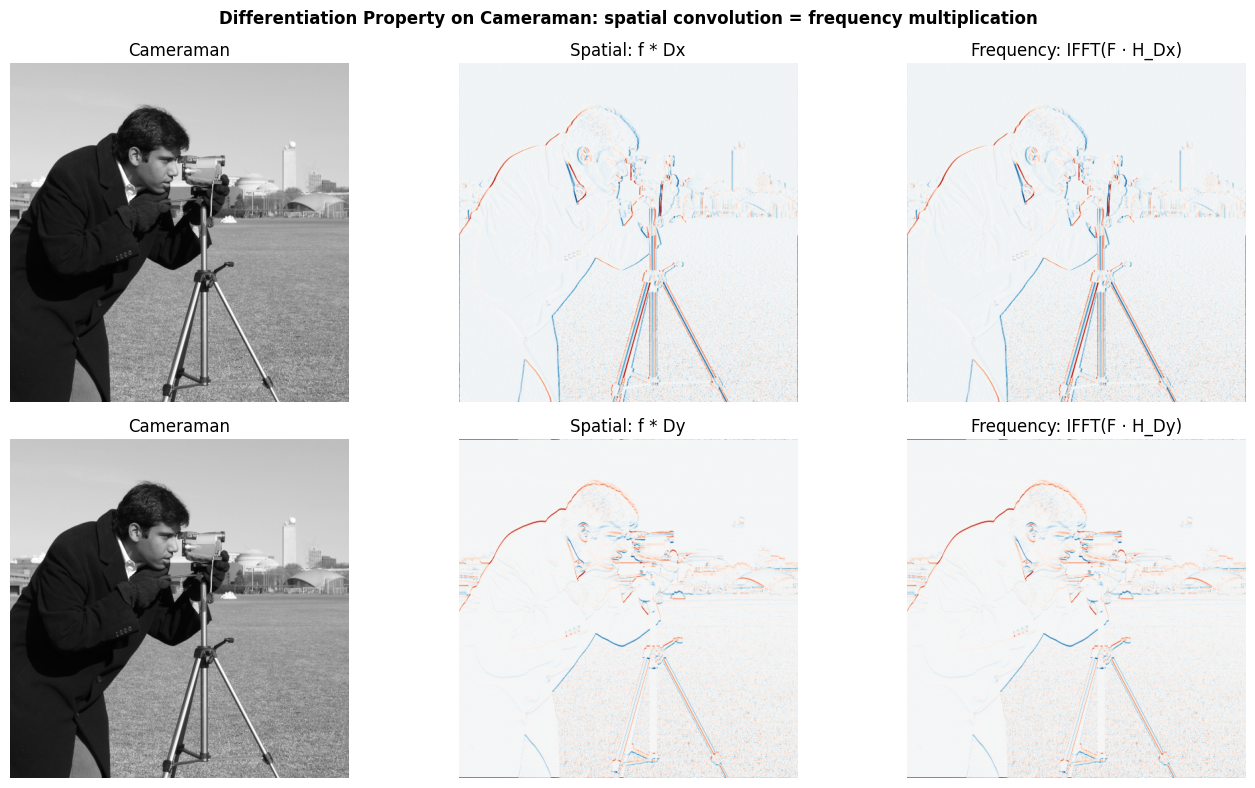

∂f/∂x  max diff: 3.33e-16
∂f/∂y  max diff: 4.46e-16


In [26]:
# Differentiation property on cameraman
N_cam = 512
cam = cv2.imread("cameraman.jpeg", cv2.IMREAD_GRAYSCALE)
cam = cv2.resize(cam, (N_cam, N_cam)).astype(np.float64) / 255.0

Dx = np.array([[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]])
Dy = np.array([[0, -0.5, 0], [0, 0, 0], [0, 0.5, 0]])

# Spatial
df_dx_spatial = convolve(cam, Dx, mode='wrap')
df_dy_spatial = convolve(cam, Dy, mode='wrap')

# Frequency
F = np.fft.fft2(cam)

Dx_pad = np.zeros((N_cam, N_cam)); Dx_pad[:3, :3] = Dx
Dx_pad = np.roll(np.roll(Dx_pad, -1, axis=0), -1, axis=1)
H_Dx = np.fft.fft2(Dx_pad)

Dy_pad = np.zeros((N_cam, N_cam)); Dy_pad[:3, :3] = Dy
Dy_pad = np.roll(np.roll(Dy_pad, -1, axis=0), -1, axis=1)
H_Dy = np.fft.fft2(Dy_pad)

df_dx_freq = np.real(np.fft.ifft2(F * H_Dx))
df_dy_freq = np.real(np.fft.ifft2(F * H_Dy))

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

axes[0,0].imshow(cam, cmap='gray')
axes[0,0].set_title("Cameraman"); axes[0,0].axis('off')
axes[0,1].imshow(df_dx_spatial, cmap='RdBu_r')
axes[0,1].set_title("Spatial: f * Dx"); axes[0,1].axis('off')
axes[0,2].imshow(df_dx_freq, cmap='RdBu_r')
axes[0,2].set_title("Frequency: IFFT(F · H_Dx)"); axes[0,2].axis('off')

axes[1,0].imshow(cam, cmap='gray')
axes[1,0].set_title("Cameraman"); axes[1,0].axis('off')
axes[1,1].imshow(df_dy_spatial, cmap='RdBu_r')
axes[1,1].set_title("Spatial: f * Dy"); axes[1,1].axis('off')
axes[1,2].imshow(df_dy_freq, cmap='RdBu_r')
axes[1,2].set_title("Frequency: IFFT(F · H_Dy)"); axes[1,2].axis('off')

fig.suptitle("Differentiation Property on Cameraman: spatial convolution = frequency multiplication",
             fontsize=12, fontweight='bold')
plt.tight_layout(); plt.show()

print(f"∂f/∂x  max diff: {np.max(np.abs(df_dx_spatial - df_dx_freq)):.2e}")
print(f"∂f/∂y  max diff: {np.max(np.abs(df_dy_spatial - df_dy_freq)):.2e}")

### Derivative-Convolution Commutativity

Differentiation and convolution commute: you can differentiate before or after convolving and get the same result.

**First-order:**

$$
\frac{\partial}{\partial x}(f * G) = f * \frac{\partial G}{\partial x}
$$

**Proof (via the convolution theorem and differentiation property):**

Let $F = \mathcal{F}\{f\}$ and $\hat{G} = \mathcal{F}\{G\}$. By the convolution theorem:

$$
\mathcal{F}\{f * G\} = F \cdot \hat{G}
$$

Differentiating the left side (differentiation property):

$$
\mathcal{F}\left\{\frac{\partial}{\partial x}(f * G)\right\} = j2\pi u \cdot F \cdot \hat{G}
$$

We can group this differently:

$$
j2\pi u \cdot F \cdot \hat{G} = F \cdot \underbrace{(j2\pi u \cdot \hat{G})}_{\mathcal{F}\left\{\frac{\partial G}{\partial x}\right\}}
$$

Applying the convolution theorem in reverse:

$$
F \cdot \mathcal{F}\left\{\frac{\partial G}{\partial x}\right\} = \mathcal{F}\left\{f * \frac{\partial G}{\partial x}\right\}
$$

Since both sides have the same Fourier transform, the spatial signals are equal. $\square$



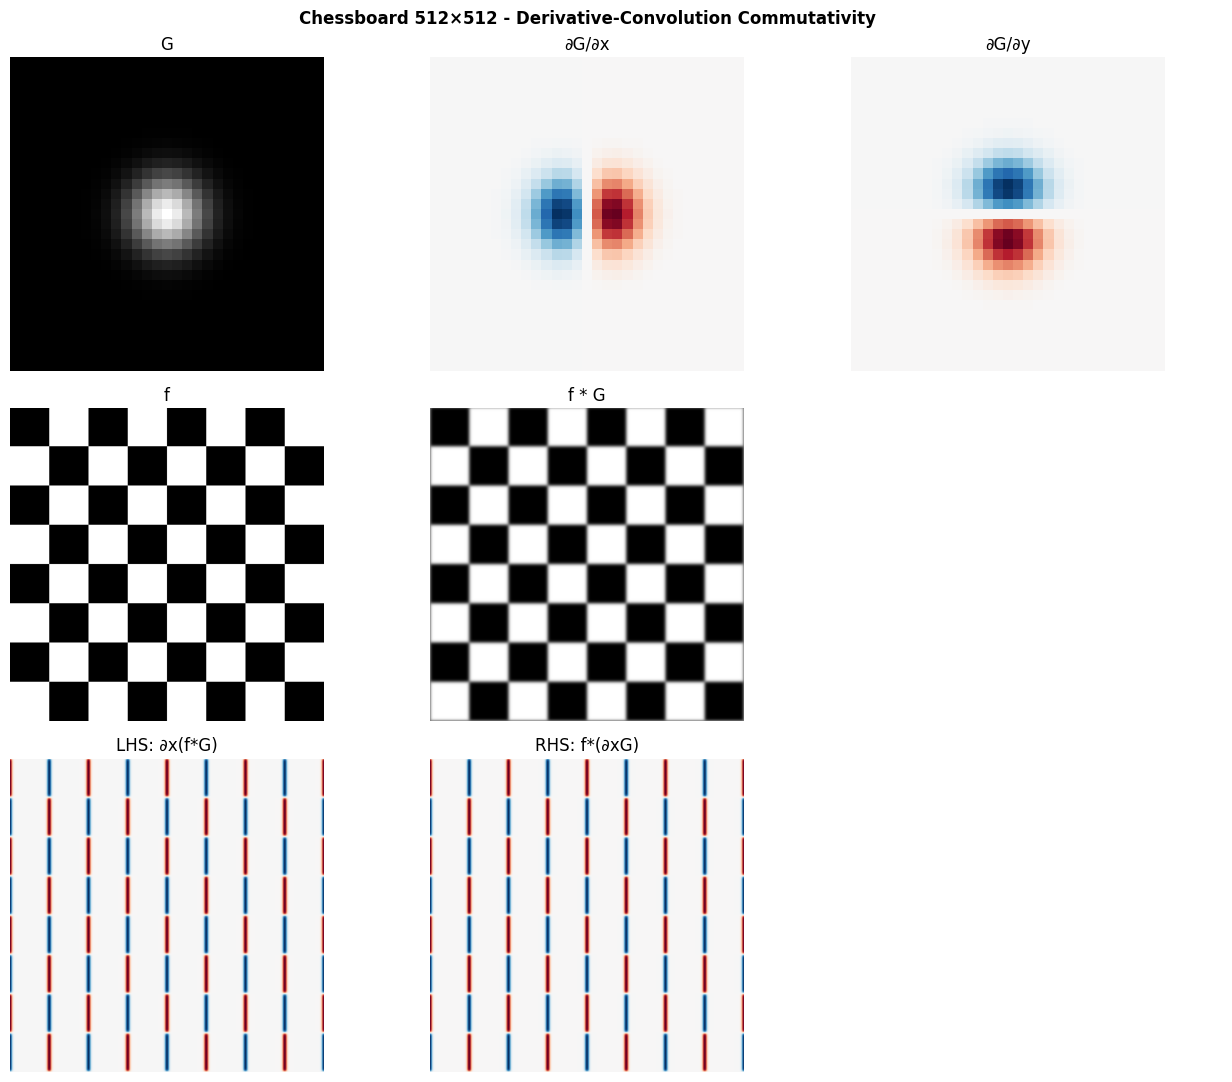

  ∂x max error: 2.43e-09,  ∂y max error: 2.43e-09


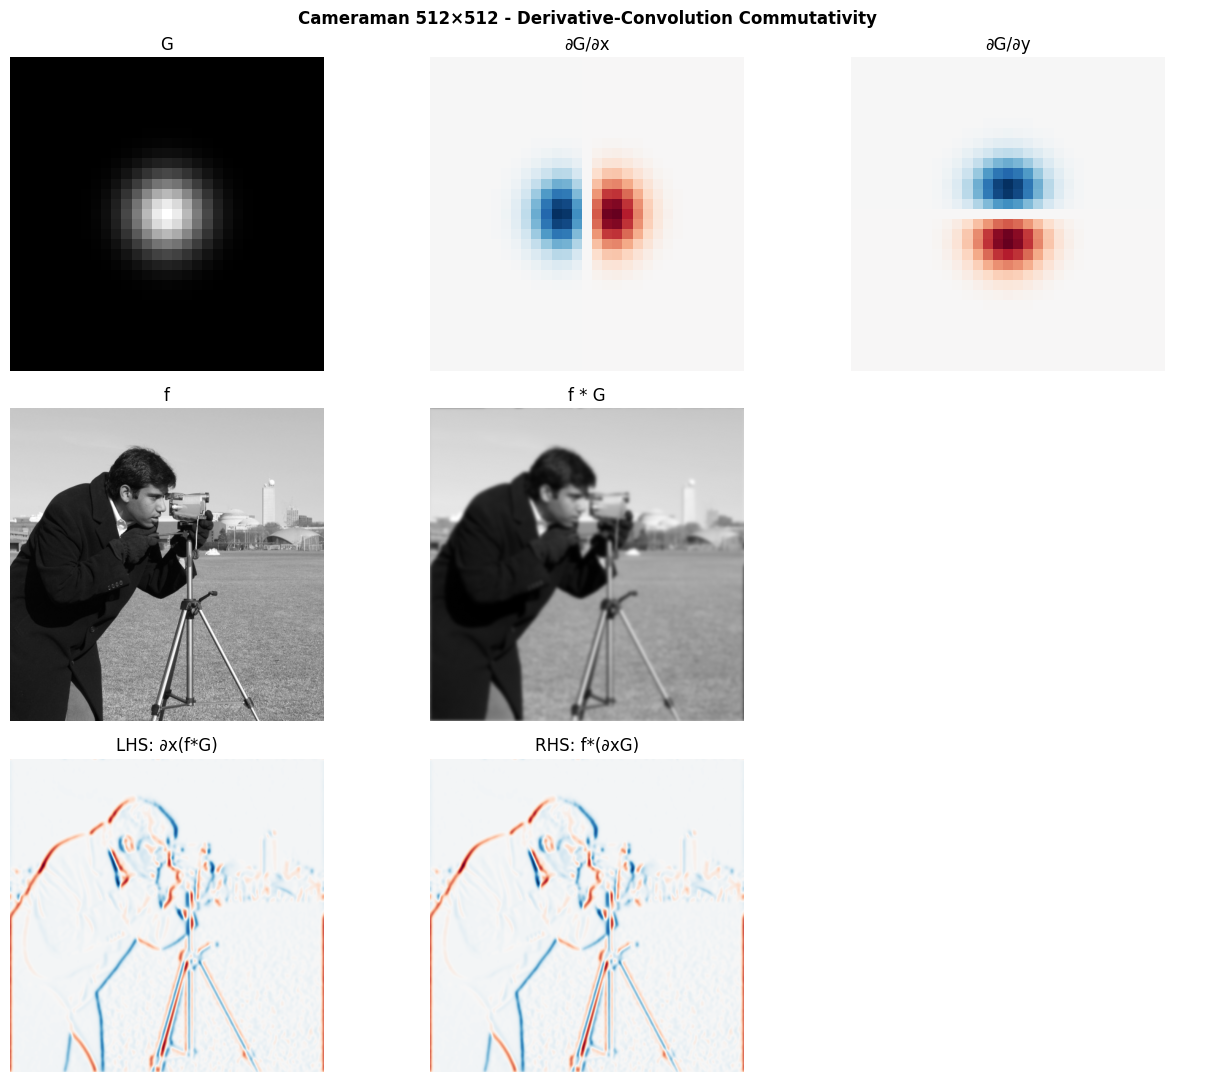

  ∂x max error: 2.25e-09,  ∂y max error: 2.21e-09


In [27]:
N = 512

def make_gaussian_kernel(ksize=31, sigma=2.5):
    ax = np.arange(-(ksize // 2), ksize // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    g = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    g /= g.sum()
    return g

sq = N // 8
x = np.arange(N)
X, Y = np.meshgrid(x, x)
chess = (((X // sq) + (Y // sq)) % 2).astype(np.float64)

cam = cv2.imread("cameraman.jpeg", cv2.IMREAD_GRAYSCALE)
cam = cv2.resize(cam, (N, N)).astype(np.float64) / 255.0

deriv_images = [
    (chess, "Chessboard 512×512"),
    (cam,   "Cameraman 512×512"),
]

def compare_first_order_derivative_2d(image, title="", ksize=31, sigma=2.5):
    f = np.asarray(image, dtype=np.float64)
    G = make_gaussian_kernel(ksize, sigma)

    Dx = np.array([[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]], dtype=np.float64)
    Dy = np.array([[0, -0.5, 0], [0, 0, 0], [0, 0.5, 0]], dtype=np.float64)

    f_smooth = convolve(f, G, mode='wrap')

    dGdx = convolve(G, Dx, mode='wrap')
    dGdy = convolve(G, Dy, mode='wrap')

    lhs_x = convolve(f_smooth, Dx, mode='wrap')
    lhs_y = convolve(f_smooth, Dy, mode='wrap')

    rhs_x = convolve(f, dGdx, mode='wrap')
    rhs_y = convolve(f, dGdy, mode='wrap')

    err_x = np.max(np.abs(lhs_x - rhs_x))
    err_y = np.max(np.abs(lhs_y - rhs_y))

    fig, axes = plt.subplots(3, 3, figsize=(13, 11))

    # Row 0: kernels
    axes[0,0].imshow(G, cmap='gray', interpolation='nearest')
    axes[0,0].set_title("G"); axes[0,0].axis('off')

    axes[0,1].imshow(dGdx, cmap='RdBu_r', interpolation='nearest')
    axes[0,1].set_title("∂G/∂x"); axes[0,1].axis('off')

    axes[0,2].imshow(dGdy, cmap='RdBu_r', interpolation='nearest')
    axes[0,2].set_title("∂G/∂y"); axes[0,2].axis('off')

    # Row 1: image and smoothed
    axes[1,0].imshow(f, cmap='gray')
    axes[1,0].set_title("f"); axes[1,0].axis('off')

    axes[1,1].imshow(f_smooth, cmap='gray')
    axes[1,1].set_title("f * G"); axes[1,1].axis('off')

    axes[1,2].axis('off')

    # Row 2: LHS vs RHS (x-direction shown, y printed)
    axes[2,0].imshow(lhs_x, cmap='RdBu_r')
    axes[2,0].set_title("LHS: ∂x(f*G)"); axes[2,0].axis('off')

    axes[2,1].imshow(rhs_x, cmap='RdBu_r')
    axes[2,1].set_title("RHS: f*(∂xG)"); axes[2,1].axis('off')

    axes[2,2].axis('off')

    fig.suptitle(f"{title} - Derivative-Convolution Commutativity", fontsize=12, fontweight='bold')
    plt.tight_layout(); plt.show()

    print(f"  ∂x max error: {err_x:.2e},  ∂y max error: {err_y:.2e}")

for img_arr, name in deriv_images:
    compare_first_order_derivative_2d(img_arr, title=name)

### Exercise - Laplacian and Convolution

The same property extends to the **2D Laplacian**:

$$
\nabla^2 (f * G) = f * (\nabla^2 G)
$$

**Why is the Laplacian kernel what it is?**

The Laplacian is the sum of second-order partial derivatives:

$$
\nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}
$$

The second derivative in one direction is approximated by the central-difference formula:

$$
\frac{\partial^2 f}{\partial x^2} \approx f[x+1, y] - 2f[x, y] + f[x-1, y] \quad \Longrightarrow \quad \text{kernel } [1, -2, 1]
$$

$$
\frac{\partial^2 f}{\partial y^2} \approx f[x, y+1] - 2f[x, y] + f[x, y-1] \quad \Longrightarrow \quad \text{kernel } \begin{bmatrix} 1 \\ -2 \\ 1 \end{bmatrix}
$$

Adding both as 2D kernels:

$$
\nabla^2 \approx \begin{bmatrix} 0 & 0 & 0 \\ 1 & -2 & 1 \\ 0 & 0 & 0 \end{bmatrix} + \begin{bmatrix} 0 & 1 & 0 \\ 0 & -2 & 0 \\ 0 & 1 & 0 \end{bmatrix} = \begin{bmatrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{bmatrix}
$$

The center value $-4$ is the sum of the two $-2$ terms, and the four neighbors each contribute $+1$. This kernel measures how much a pixel differs from the average of its 4-connected neighbors.

**Task:** Using the same approach as the first-order demo above, show that applying the Laplacian after Gaussian smoothing is equivalent to convolving the image with the Laplacian-of-Gaussian for the test images.

Compare the two paths and plot the results for the checkerboard and cameraman images.

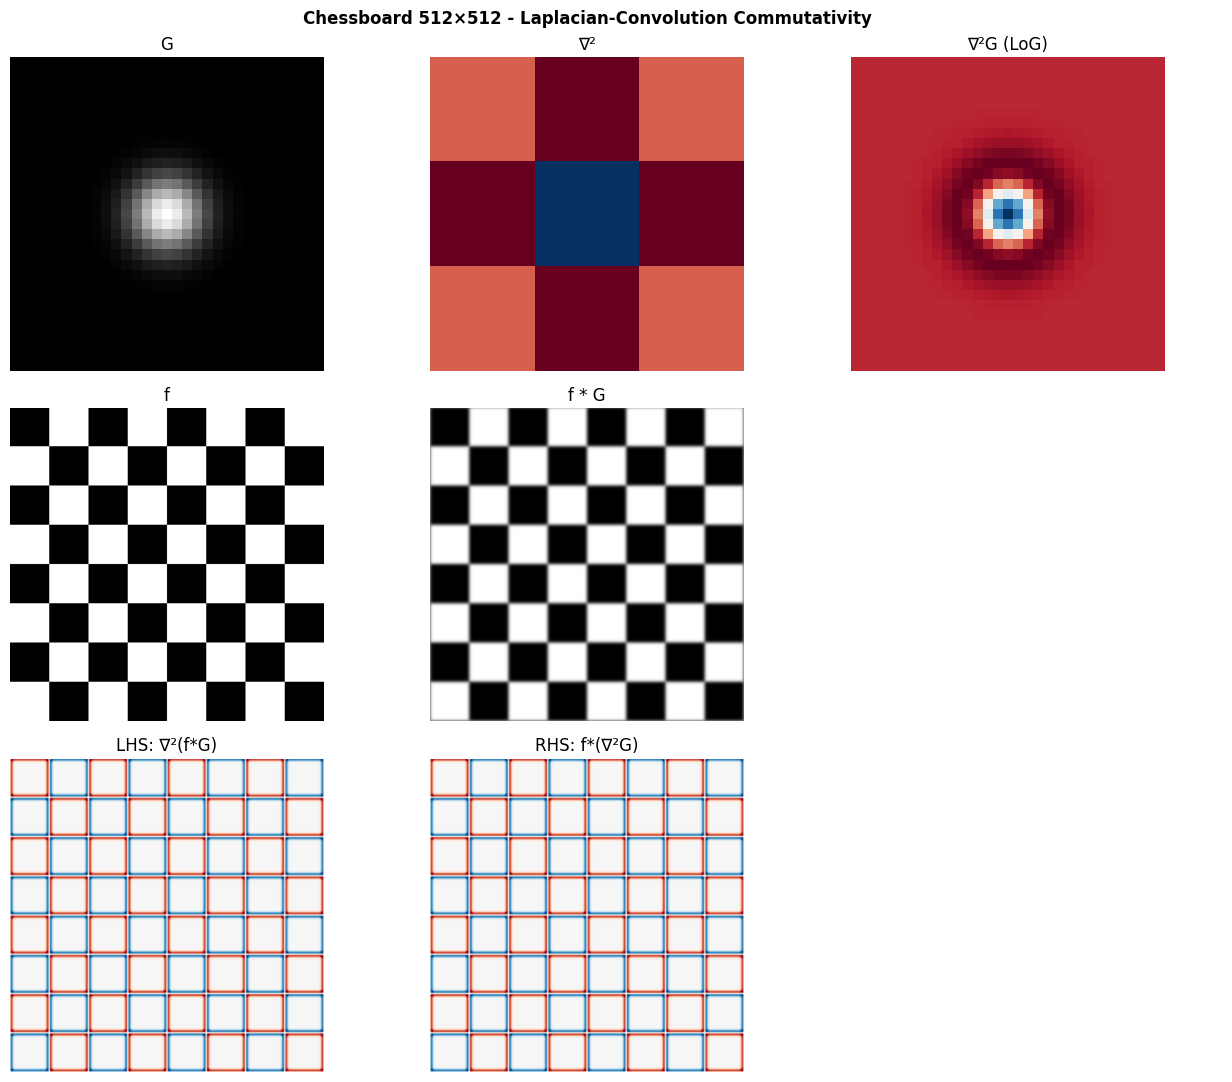

  Max error (LHS vs RHS): 4.86e-09


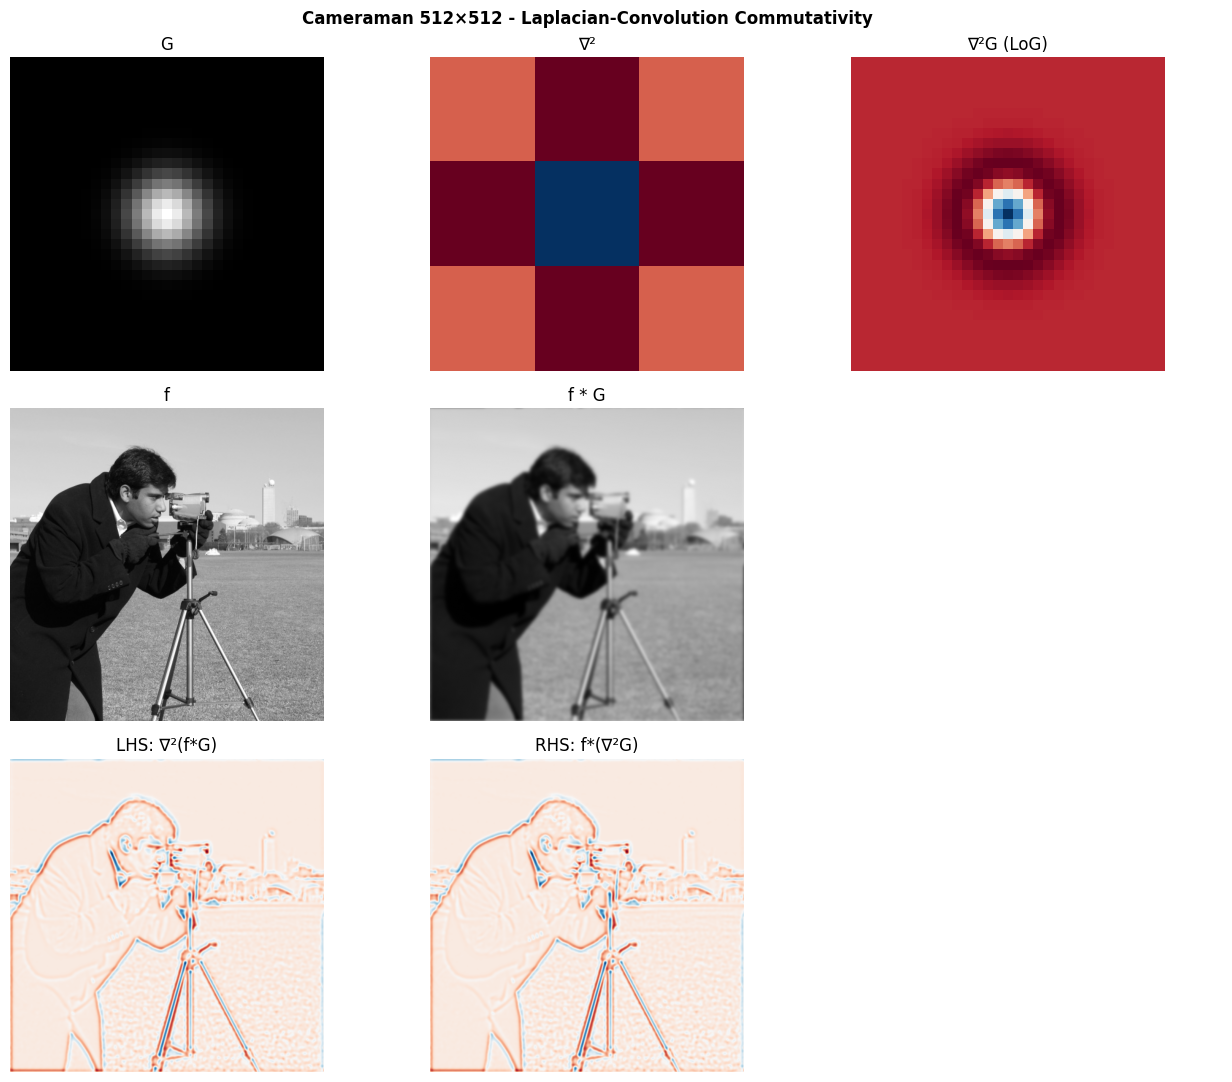

  Max error (LHS vs RHS): 2.68e-09


In [28]:
def compare_laplacian_property(image, title="", ksize=31, sigma=2.5):
    f = np.asarray(image, dtype=np.float64)
    G = make_gaussian_kernel(ksize, sigma)

    # 4-connected Laplacian kernel
    Lap = np.array([[0, 1, 0],
                    [1, -4, 1],
                    [0, 1, 0]], dtype=np.float64)

    # Smooth image
    f_smooth = convolve(f, G, mode='wrap')

    # LHS: ∇²(f * G)
    lhs = convolve(f_smooth, Lap, mode='wrap')

    # ∇²G  (Laplacian of Gaussian kernel)
    lap_G = convolve(G, Lap, mode='wrap')

    # RHS: f * (∇²G)
    rhs = convolve(f, lap_G, mode='wrap')

    err = np.max(np.abs(lhs - rhs))

    fig, axes = plt.subplots(3, 3, figsize=(13, 11))

    # kernels
    axes[0,0].imshow(G, cmap='gray', interpolation='nearest')
    axes[0,0].set_title("G"); axes[0,0].axis('off')

    axes[0,1].imshow(Lap, cmap='RdBu_r', interpolation='nearest')
    axes[0,1].set_title("∇²"); axes[0,1].axis('off')

    axes[0,2].imshow(lap_G, cmap='RdBu_r', interpolation='nearest')
    axes[0,2].set_title("∇²G (LoG)"); axes[0,2].axis('off')

    # image and smoothed
    axes[1,0].imshow(f, cmap='gray')
    axes[1,0].set_title("f"); axes[1,0].axis('off')

    axes[1,1].imshow(f_smooth, cmap='gray')
    axes[1,1].set_title("f * G"); axes[1,1].axis('off')

    axes[1,2].axis('off')

    # LHS vs RHS
    axes[2,0].imshow(lhs, cmap='RdBu_r')
    axes[2,0].set_title("LHS: ∇²(f*G)"); axes[2,0].axis('off')

    axes[2,1].imshow(rhs, cmap='RdBu_r')
    axes[2,1].set_title("RHS: f*(∇²G)"); axes[2,1].axis('off')

    axes[2,2].axis('off')

    fig.suptitle(f"{title} - Laplacian-Convolution Commutativity",
                 fontsize=12, fontweight='bold')
    plt.tight_layout(); plt.show()

    print(f"  Max error (LHS vs RHS): {err:.2e}")


for img_arr, name in deriv_images:
    compare_laplacian_property(img_arr, title=name, ksize=31, sigma=2.5)

### 8 Scaling Property

Compressing a signal in space **stretches** it in frequency, and vice versa:

$$f(ax,\; by) \;\longleftrightarrow\; \frac{1}{|ab|}\, F\!\left(\frac{u}{a},\;\frac{v}{b}\right)$$

We show two 2D Gaussians, a narrow one ($\sigma = 0.3$) and a wide one ($\sigma = 1.5$).  
The narrow Gaussian produces a wide spectrum, and the wide Gaussian produces a narrow spectrum.

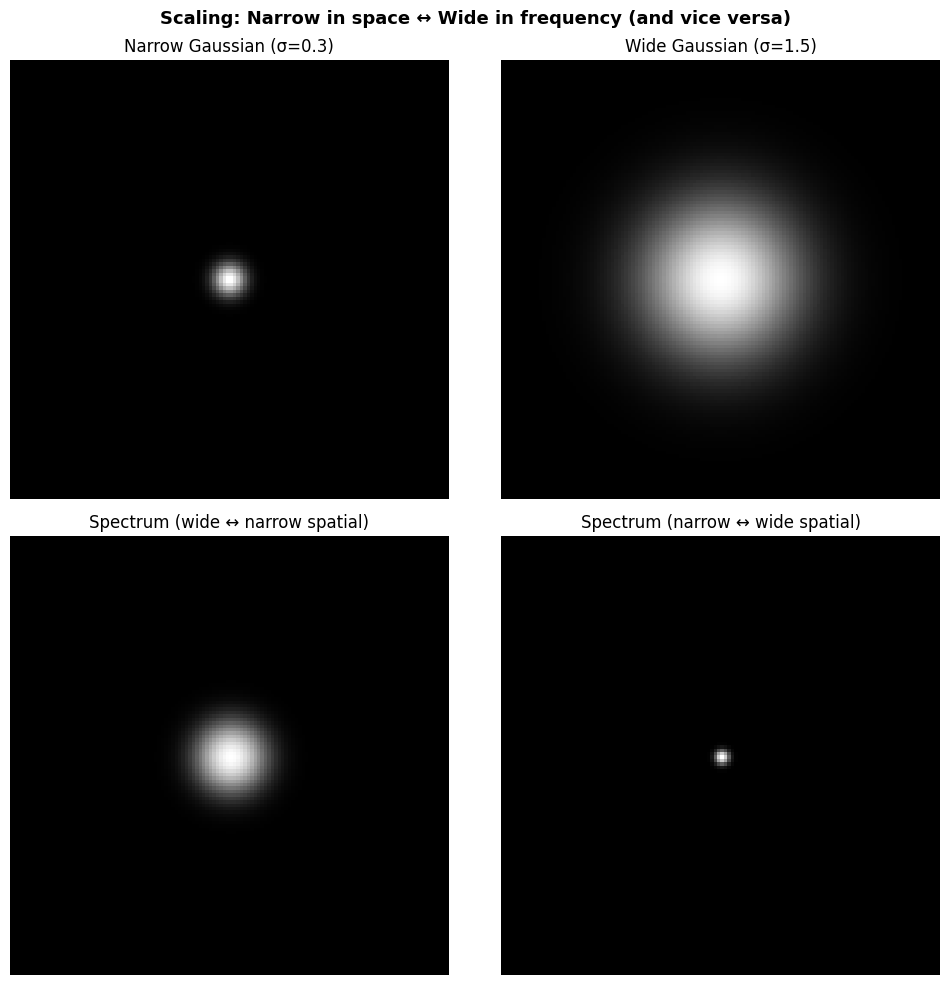

In [29]:
N = PROP_SIZE
x = np.linspace(-6, 6, N)
xx, yy = np.meshgrid(x, x)

sigma1, sigma2 = 0.3, 1.5
g_narrow = np.exp(-(xx**2 + yy**2) / (2 * sigma1**2))
g_wide   = np.exp(-(xx**2 + yy**2) / (2 * sigma2**2))

mag_narrow = np.abs(np.fft.fftshift(np.fft.fft2(g_narrow)))
mag_wide   = np.abs(np.fft.fftshift(np.fft.fft2(g_wide)))

# Normalize each to [0, 1] so log-scaling is comparable
mag_narrow_norm = np.log1p(mag_narrow / mag_narrow.max())
mag_wide_norm   = np.log1p(mag_wide / mag_wide.max())

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(g_narrow, cmap='gray'); axes[0,0].set_title(f"Narrow Gaussian (σ={sigma1})"); axes[0,0].axis('off')
axes[0,1].imshow(g_wide, cmap='gray');   axes[0,1].set_title(f"Wide Gaussian (σ={sigma2})"); axes[0,1].axis('off')

axes[1,0].imshow(mag_narrow_norm, cmap='gray'); axes[1,0].set_title("Spectrum (wide ↔ narrow spatial)"); axes[1,0].axis('off')
axes[1,1].imshow(mag_wide_norm, cmap='gray');   axes[1,1].set_title("Spectrum (narrow ↔ wide spatial)"); axes[1,1].axis('off')

fig.suptitle("Scaling: Narrow in space ↔ Wide in frequency (and vice versa)", fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

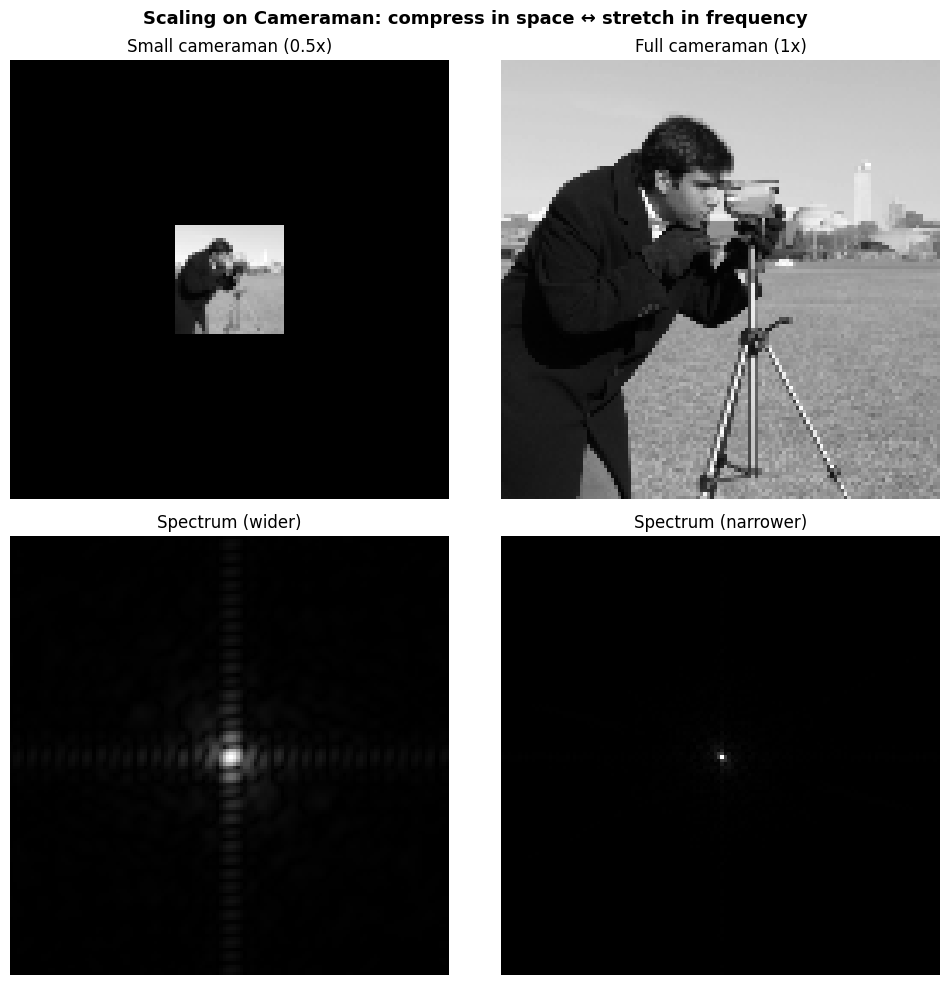

In [30]:
# Scaling on cameraman: small vs large version
N = PROP_SIZE

half = N // 4
cam_small = cv2.resize(cam_prop, (half, half), interpolation=cv2.INTER_AREA)
cam_narrow = np.zeros((N, N))
offset = (N - half) // 2
cam_narrow[offset:offset+half, offset:offset+half] = cam_small

cam_wide = cam_prop.copy()

mag_narrow = np.abs(np.fft.fftshift(np.fft.fft2(cam_narrow)))
mag_wide   = np.abs(np.fft.fftshift(np.fft.fft2(cam_wide)))

mag_narrow_norm = np.log1p(mag_narrow / mag_narrow.max())
mag_wide_norm   = np.log1p(mag_wide / mag_wide.max())

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(cam_narrow, cmap='gray'); axes[0,0].set_title("Small cameraman (0.5x)"); axes[0,0].axis('off')
axes[0,1].imshow(cam_wide, cmap='gray');   axes[0,1].set_title("Full cameraman (1x)"); axes[0,1].axis('off')

axes[1,0].imshow(mag_narrow_norm, cmap='gray'); axes[1,0].set_title("Spectrum (wider)"); axes[1,0].axis('off')
axes[1,1].imshow(mag_wide_norm, cmap='gray');   axes[1,1].set_title("Spectrum (narrower)"); axes[1,1].axis('off')

fig.suptitle("Scaling on Cameraman: compress in space ↔ stretch in frequency", fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

### Exercise: Downsampling, Upsampling, and Aliasing

The scaling property tells us that shrinking an image stretches its spectrum. If the stretched spectrum exceeds the Nyquist limit ($k = N/2$), frequencies **fold back** (alias) and corrupt the image.

**Tasks:**

1. **Naive downsampling:** Take the cameraman image at 512×512 and downsample by factors of 2, 4, and 8 by simply keeping every $s$-th pixel (`cam[::s, ::s]`). Display each downsampled image upscaled back to 512×512 using nearest-neighbor interpolation. What artifacts do you see? Look at fine textures (grass, tripod).

2. **Proper downsampling (anti-aliasing):** Before downsampling by factor $s$, blur the image with a Gaussian of $\sigma \approx s/2$ to suppress frequencies above the new Nyquist limit. Then subsample. Compare with the naive version. Are the artifacts reduced?

3. **Compare spectra:** For each downsampling factor, plot the magnitude spectrum of the naively downsampled image and the anti-aliased version. In the naive case, can you see aliased energy (high-frequency content that should not be there)?

4. **Upsampling:** Take a 64×64 cameraman and upsample to 512×512 using (a) nearest-neighbor, (b) bilinear, and (c) bicubic interpolation. Compare the spectra. Which method introduces the least high-frequency artifacts?

**Questions to think about:**

- Why does naive downsampling by 2 correspond to stretching the spectrum by 2? What happens when the stretched spectrum exceeds $[-\pi, \pi]$?
- Why is Gaussian blurring the right pre-filter? How does its cutoff relate to the downsampling factor?


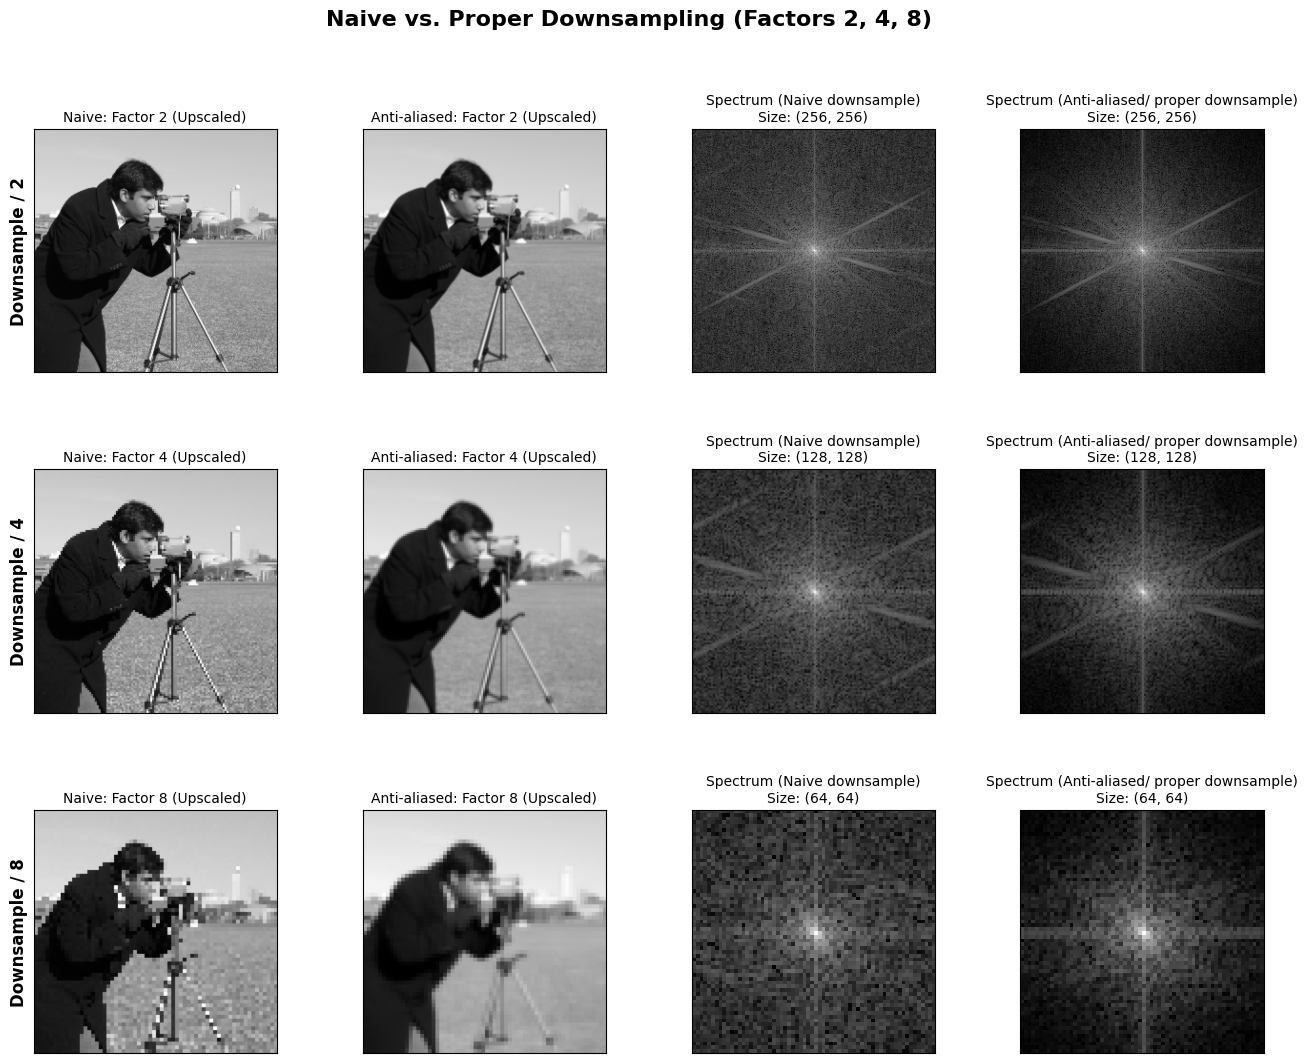

In [33]:
from scipy.ndimage import gaussian_filter

def get_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return np.log1p(np.abs(fshift))

factors = [2, 4, 8]

fig, axes = plt.subplots(len(factors), 4, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, s in enumerate(factors):
    # 1. Naive Downsampling
    naive_small = img[::s, ::s]
    # upscale for visualization (Nearest Neighbor to see pixels/artifacts clearly)
    naive_show = cv2.resize(naive_small, (512, 512), interpolation=cv2.INTER_NEAREST)

    # 2. Proper Downsampling (Anti-aliasing)
    # blur first, then skip pixels. sigma is approx s/2
    sigma = s / 2
    img_blurred = gaussian_filter(img, sigma=sigma)
    proper_small = img_blurred[::s, ::s]
    proper_show = cv2.resize(proper_small, (512, 512), interpolation=cv2.INTER_NEAREST)

    # 3. Spectra Calculation (on the small downsampled images)
    spec_naive = get_spectrum(naive_small)
    spec_proper = get_spectrum(proper_small)


    axes[i, 0].imshow(naive_show, cmap='gray')
    axes[i, 0].set_title(f"Naive: Factor {s} (Upscaled)", fontsize=10)
    axes[i, 0].set_ylabel(f"Downsample / {s}", fontsize=12, fontweight='bold')


    axes[i, 1].imshow(proper_show, cmap='gray')
    axes[i, 1].set_title(f"Anti-aliased: Factor {s} (Upscaled)", fontsize=10)


    axes[i, 2].imshow(spec_naive, cmap='gray')
    axes[i, 2].set_title(f"Spectrum (Naive downsample)\nSize: {naive_small.shape}", fontsize=10)


    axes[i, 3].imshow(spec_proper, cmap='gray')
    axes[i, 3].set_title(f"Spectrum (Anti-aliased/ proper downsample)\nSize: {proper_small.shape}", fontsize=10)


    for ax in axes[i]:
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle("Naive vs. Proper Downsampling (Factors 2, 4, 8)", fontsize=16, fontweight='bold')
plt.show()

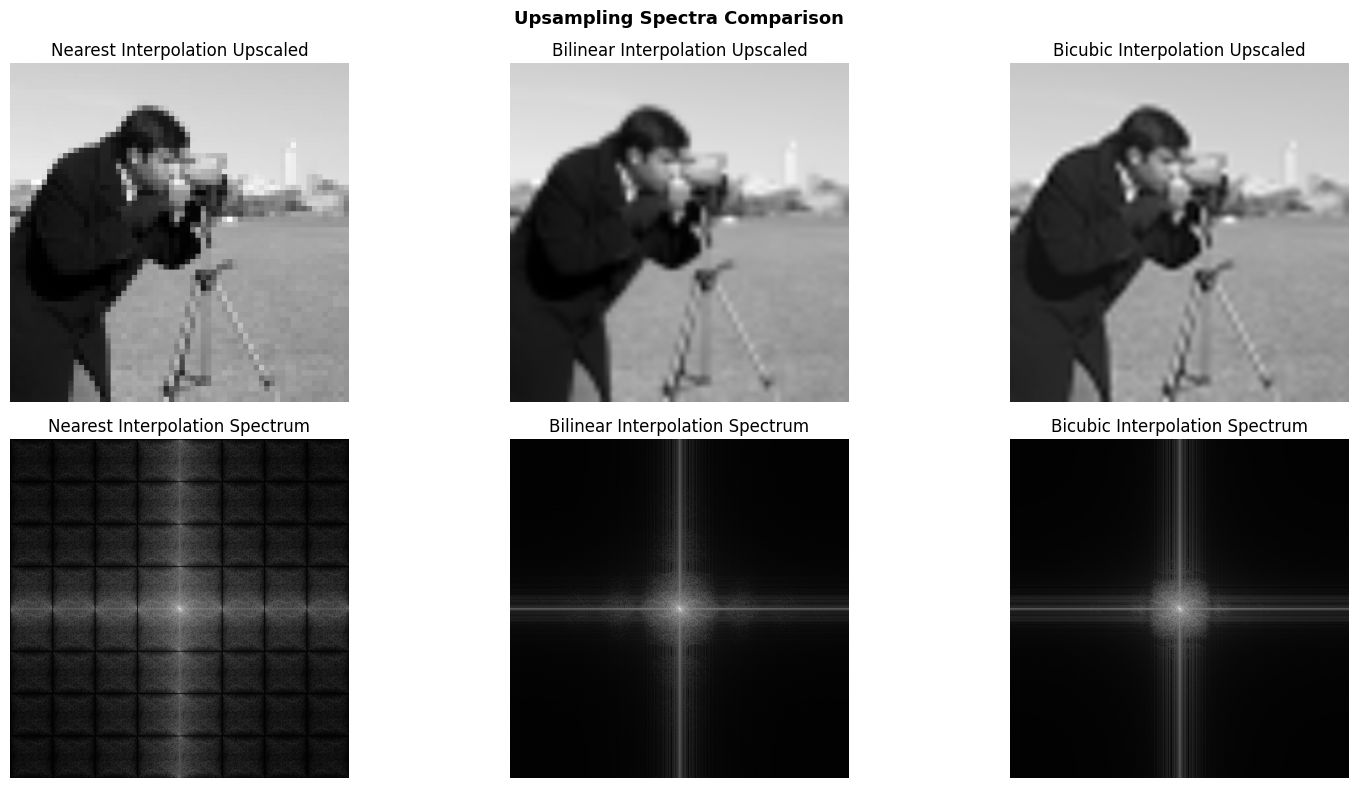

In [35]:
# Upsampling Methods
small = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA) # shrinking via using INTER_AREA method rather than default INTER_LINEAR (we will use it in upsampling step also...)

methods = [("Nearest", cv2.INTER_NEAREST), ("Bilinear", cv2.INTER_LINEAR), ("Bicubic", cv2.INTER_CUBIC)]
fig2, ax2 = plt.subplots(2, 3, figsize=(16, 8))

for i, (name, method) in enumerate(methods):
    upsampled = cv2.resize(small, (512, 512), interpolation=method)
    spec = get_spectrum(upsampled)
    ax2[0,i].imshow(upsampled, cmap='gray')
    ax2[0,i].set_title(f"{name} Interpolation Upscaled")
    ax2[0,i].axis('off')
    ax2[1,i].imshow(spec, cmap='gray')
    ax2[1,i].set_title(f"{name} Interpolation Spectrum")
    ax2[1,i].axis('off')

plt.suptitle("Upsampling Spectra Comparison", fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

### Answers to "Tasks"

**1. Naive Downsampling Artifacts**

* **Observation:** You will see "jagged" edges and Moiré patterns, particularly in the fine textures of the grass and the camera tripod legs.
* **Reason:** High-frequency details (like the fine lines of the tripod) occur more frequently than the new sampling rate can capture. These frequencies are "misidentified" as lower frequencies, creating false patterns.

**2. Proper Downsampling (Anti-aliasing)**

* **Observation:** The image is blurrier, but the distracting "shimmering" or jagged artifacts (Moiré) are gone.
* **Reason:** The Gaussian blur removes the high frequencies *before* the downsampling step. Since the high-frequency content is removed, it cannot "fold back" to corrupt the lower frequencies.

**3. Spectral Comparison**

* **Naive Spectrum:** Shows high energy scattered throughout, even at the edges. This is "aliased energy"—high-frequency signals from the original image that folded over and now appear as noise or wrong patterns in the available frequency space.
* **Anti-aliased Spectrum:** Looks cleaner and more concentrated at the center. The high frequencies were suppressed by the Gaussian filter (which acts as a low-pass filter) before they could alias.

**4. Upsampling Spectra**

* **Nearest Neighbor:** The spectrum has a grid-like, "blocky" pattern extending far out. This introduces significant high-frequency artifacts (sharp edges of the blocks).
* **Bicubic/Bilinear:** The spectrum decays much faster away from the center. Bicubic generally preserves the central shape best while suppressing the high-frequency grid artifacts seen in nearest-neighbor.

### Answers to "Questions to think about:"
**Q1. Why does naive downsampling by 2 correspond to stretching the spectrum by 2? What happens when the stretched spectrum exceeds ?**

**Answer:**
According to the scaling property, compressing a signal in the spatial domain (which downsampling effectively does) directly results in **stretching its spectrum** in the frequency domain. When this stretched spectrum expands beyond the Nyquist limit of , the frequencies outside this range **fold back (alias)** into the valid range, appearing as false low-frequency patterns or noise.

**Q2. Why is Gaussian blurring the right pre-filter? How does its cutoff relate to the downsampling factor?**

**Answer:**
Gaussian blurring functions as a **low-pass filter**, removing high-frequency details that would otherwise cause aliasing when the image is downsampled. The blur's standard deviation (cutoff) is set to , where  is the downsampling factor; this ensures that frequencies above the new, lower Nyquist limit are suppressed before the sampling occurs.